### Case Study: Predict WikiPedia Page Visits (Time Series Forecasting)

<b>Problem Statement:<b>
    
Develope different types of time series models to forecast the wikipedia page views on future days for various global spoken languages such as:

 - zh  (Chinese)
 - fr  (French)
 - en  (English)
 - ru  (Russian)
 - de  (German)
 - ja  (Japanese)
 - es  (Spanish)


<b>Import data and perform EDA<b>

In [107]:
# Import Libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
from fbprophet import Prophet
import warnings
import logging

In [108]:
# Set Global variables/parameters

pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
log = logging.getLogger()
log.setLevel(logging.ERROR)

In [4]:
# Read the CSV data into the pandas dataframe

df = pd.read_csv('train_1.csv')

In [5]:
# Make a copy of the dataframe

df_train = df.copy()

In [6]:
# Print shape of the dataframe

df_train.shape

(145063, 551)

In [7]:
# Get the glimpse of the data

df_train.head()

Page  2015-07-01  \
0              2NE1_zh.wikipedia.org_all-access_spider        18.0   
1               2PM_zh.wikipedia.org_all-access_spider        11.0   
2                3C_zh.wikipedia.org_all-access_spider         1.0   
3           4minute_zh.wikipedia.org_all-access_spider        35.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider         NaN   

   2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  \
0        11.0         5.0        13.0        14.0         9.0         9.0   
1        14.0        15.0        18.0        11.0        13.0        22.0   
2         0.0         1.0         1.0         0.0         4.0         0.0   
3        13.0        10.0        94.0         4.0        26.0        14.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-08  2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  \
0        22.0        26.0  ...        32.0        63.0        15.0   
1        11.0        10.0  ...        17.0        42.0        28.0   
2         3.0         4.0  ...         3.0         1.0         1.0   
3         9.0        11.0  ...        32.0        10.0        26.0   
4         NaN         NaN  ...        48.0         9.0        25.0   

   2016-12-25  2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  \
0        26.0        14.0        20.0        22.0        19.0        18.0   
1        15.0         9.0        30.0        52.0        45.0        26.0   
2         7.0         4.0         4.0         6.0         3.0         4.0   
3        27.0        16.0        11.0        17.0        19.0        10.0   
4        13.0         3.0        11.0        27.0        13.0        36.0   

   2016-12-31  
0        20.0  
1        20.0  
2        17.0  
3        11.0  
4        10.0  

[5 rows x 551 columns]

In [8]:
# Get the list of all columns

df_train.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

In [9]:
# Check if there are any null values

df_train.isna().sum().sum()

6192931

 - We found null values but those will be taken care of while doing the aggregation based on language
 - We are not going to worry about the nulls as of now until datasets are separated based on language

In [10]:
# We need to split the page into different categories. So get the glimpse of the page field

df_train['Page'].head()

0                2NE1_zh.wikipedia.org_all-access_spider
1                 2PM_zh.wikipedia.org_all-access_spider
2                  3C_zh.wikipedia.org_all-access_spider
3             4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider
Name: Page, dtype: object

In [11]:
# Define function to pass to the apply function

def func_split(x, i):
    try:
        return x[i]
    
    except:
        return np.nan

In [12]:
# Split the page into fields - Specific name, language, access type, access origin

df_train['t1'] = df_train['Page'].str.split('.wikipedia').apply(lambda x: func_split(x, 0))
df_train['t2'] = df_train['Page'].str.split('.wikipedia').apply(lambda x: func_split(x, 1))
df_train['Specific_name'] = df_train['t1'].str.rsplit('_',1).apply(lambda x: func_split(x, 0))
df_train['Language']      = df_train['t1'].str.rsplit('_',1).apply(lambda x: func_split(x, 1))
df_train['t2']            = df_train['t2'].str.split('.org_').apply(lambda x: func_split(x,1))
df_train['Access_type']   = df_train['t2'].str.rsplit('_',1).apply(lambda x: func_split(x, 0))
df_train['Access_origin'] = df_train['t2'].str.rsplit('_',1).apply(lambda x: func_split(x, 1))

In [13]:
# check for any null values in newly created features 

print(df_train['Specific_name'].isna().sum())
print(df_train['Language'].isna().sum())
print(df_train['Access_type'].isna().sum())
print(df_train['Access_origin'].isna().sum())

0
1
17848
17848


In [14]:
# Check for null value records

df_train.loc[df_train['Language'].isna()]

Page  \
21914  Manual:Pywikipediabot_www.mediawiki.org_mobile-web_all-agents   

       2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
21914         2.0         0.0         0.0         0.0         0.0         1.0   

       2015-07-07  2015-07-08  2015-07-09  ...  2016-12-28  2016-12-29  \
21914         0.0         0.0         1.0  ...         1.0         0.0   

       2016-12-30  2016-12-31        t1                     t2  Specific_name  \
21914         0.0         2.0  Manual:P  mobile-web_all-agents       Manual:P   

       Language  Access_type  Access_origin  
21914       NaN   mobile-web     all-agents  

[1 rows x 557 columns]

In [15]:
# Remove null value record

df_train = df_train.loc[~df_train['Language'].isna()]

In [16]:
# Check for null value records 

df_train.loc[df_train['Access_type'].isna()]['Page']

13332                  Accueil_commons.wikimedia.org_all-access_spider
13333            Atlas_of_Asia_commons.wikimedia.org_all-access_spider
13334          Atlas_of_Europe_commons.wikimedia.org_all-access_spider
13335    Atlas_of_World_War_II_commons.wikimedia.org_all-access_spider
13336     Atlas_of_colonialism_commons.wikimedia.org_all-access_spider
                                     ...                              
84730                help:contents_www.mediawiki.org_all-access_spider
84731            how_to_contribute_www.mediawiki.org_all-access_spider
84732                    mediawiki_www.mediawiki.org_all-access_spider
84733                 special:book_www.mediawiki.org_all-access_spider
84734            special:translate_www.mediawiki.org_all-access_spider
Name: Page, Length: 17848, dtype: object

In [17]:
# Remove null value records 

df_train = df_train.loc[~df_train['Access_type'].isna()]

In [18]:
# Check for any remaining null values

print(df_train['Specific_name'].isna().sum())
print(df_train['Language'].isna().sum())
print(df_train['Access_type'].isna().sum())
print(df_train['Access_origin'].isna().sum())

0
0
0
0


In [19]:
# Drop unwanted columns and get the glimpse of the dataset 

dff = df_train.drop(['Page','t1','t2'], axis=1)
dff.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-26  \
0         9.0        22.0        26.0        24.0  ...        14.0   
1        22.0        11.0        10.0         4.0  ...         9.0   
2         0.0         3.0         4.0         4.0  ...         4.0   
3        14.0         9.0        11.0        16.0  ...        16.0   
4         NaN         NaN         NaN         NaN  ...         3.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  \
0        20.0        22.0        19.0        18.0        20.0   
1        30.0        52.0        45.0        26.0        20.0   
2         4.0         6.0         3.0         4.0        17.0   
3        11.0        17.0        19.0        10.0        11.0   
4        11.0        27.0        13.0        36.0        10.0   

      Specific_name  Language  Access_type  Access_origin  
0              2NE1        zh   all-access         spider  
1               2PM        zh   all-access         spider  
2                3C        zh   all-access         spider  
3           4minute        zh   all-access         spider  
4  52_Hz_I_Love_You        zh   all-access         spider  

[5 rows x 554 columns]

In [20]:
# Re-arrange the dataset fields

cols = []

for c in dff.columns.to_list()[-4:]:
    cols.append(c)

for c in dff.columns.to_list()[:-4]:
    cols.append(c)

dff = dff[cols]

In [21]:
# Remove non-wikipedia pages from the dataset

dff = dff.loc[~(dff['Language']=='gotthard-basistunnel02')]

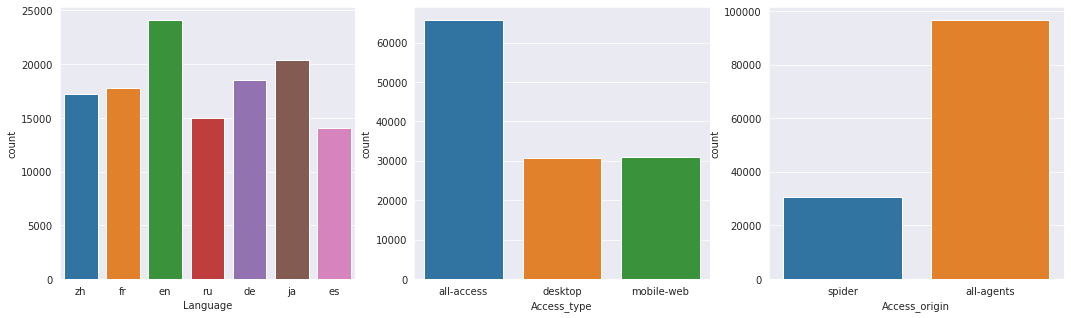

In [22]:
# Get the countplot of number of visits per Language/Access type/Access origin

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(data=dff, x='Language')
plt.subplot(1,3,2)
sns.countplot(data=dff, x='Access_type')
plt.subplot(1,3,3)
sns.countplot(data=dff, x='Access_origin')
plt.show()

In [23]:
# We want to develope the time series based on Language. So drop the other features

dft = dff.drop(['Specific_name','Access_type','Access_origin'], axis=1)

In [24]:
# Get the glimpse of the dataframe 

dft.head()

Language  2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
0       zh        18.0        11.0         5.0        13.0        14.0   
1       zh        11.0        14.0        15.0        18.0        11.0   
2       zh         1.0         0.0         1.0         1.0         0.0   
3       zh        35.0        13.0        10.0        94.0         4.0   
4       zh         NaN         NaN         NaN         NaN         NaN   

   2015-07-06  2015-07-07  2015-07-08  2015-07-09  ...  2016-12-22  \
0         9.0         9.0        22.0        26.0  ...        32.0   
1        13.0        22.0        11.0        10.0  ...        17.0   
2         4.0         0.0         3.0         4.0  ...         3.0   
3        26.0        14.0         9.0        11.0  ...        32.0   
4         NaN         NaN         NaN         NaN  ...        48.0   

   2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
0        63.0        15.0        26.0        14.0        20.0        22.0   
1        42.0        28.0        15.0         9.0        30.0        52.0   
2         1.0         1.0         7.0         4.0         4.0         6.0   
3        10.0        26.0        27.0        16.0        11.0        17.0   
4         9.0        25.0        13.0         3.0        11.0        27.0   

   2016-12-29  2016-12-30  2016-12-31  
0        19.0        18.0        20.0  
1        45.0        26.0        20.0  
2         3.0         4.0        17.0  
3        19.0        10.0        11.0  
4        13.0        36.0        10.0  

[5 rows x 551 columns]

In [25]:
# Isolate the datasets for each language

df_zh = dft.loc[dft['Language']=='zh']
df_fr = dft.loc[dft['Language']=='fr']
df_en = dft.loc[dft['Language']=='en']
df_ru = dft.loc[dft['Language']=='ru']
df_de = dft.loc[dft['Language']=='de']
df_ja = dft.loc[dft['Language']=='ja']
df_es = dft.loc[dft['Language']=='es']


In [26]:
# Drop the language column from the individual dataframes as it is no longer needed for idenfying the rec

df_zh = df_zh.drop(['Language'], axis=1)
df_fr = df_fr.drop(['Language'], axis=1)
df_en = df_en.drop(['Language'], axis=1)
df_ru = df_ru.drop(['Language'], axis=1)
df_de = df_de.drop(['Language'], axis=1)
df_ja = df_ja.drop(['Language'], axis=1)
df_es = df_es.drop(['Language'], axis=1)


In [27]:
# Bring the datasets into the format needed for time series analysis and modeling. Do the pd.melt

df_zh = pd.melt(df_zh, var_name='date', value_name='visits')
df_fr = pd.melt(df_fr, var_name='date', value_name='visits')
df_en = pd.melt(df_en, var_name='date', value_name='visits')
df_ru = pd.melt(df_ru, var_name='date', value_name='visits')
df_de = pd.melt(df_de, var_name='date', value_name='visits')
df_ja = pd.melt(df_ja, var_name='date', value_name='visits')
df_es = pd.melt(df_es, var_name='date', value_name='visits')


In [28]:
# Aggregrate the dataframe to get the total of page visits per language per date

df_zh = df_zh.groupby(['date']).sum().reset_index()
df_fr = df_fr.groupby(['date']).sum().reset_index()
df_en = df_en.groupby(['date']).sum().reset_index()
df_ru = df_ru.groupby(['date']).sum().reset_index()
df_de = df_de.groupby(['date']).sum().reset_index()
df_ja = df_ja.groupby(['date']).sum().reset_index()
df_es = df_es.groupby(['date']).sum().reset_index()


In [29]:
# As this is the time dependent data, let's sort it based on the date column

df_zh = df_zh.sort_values(['date'])
df_fr = df_fr.sort_values(['date'])
df_en = df_en.sort_values(['date'])
df_ru = df_ru.sort_values(['date'])
df_de = df_de.sort_values(['date'])
df_ja = df_ja.sort_values(['date'])
df_es = df_es.sort_values(['date'])

In [30]:
# Set the date as the index for each dataset and bring it in the time series format

df_zh = df_zh.set_index('date')
df_fr = df_fr.set_index('date')
df_en = df_en.set_index('date')
df_ru = df_ru.set_index('date')
df_de = df_de.set_index('date')
df_ja = df_ja.set_index('date')
df_es = df_es.set_index('date')

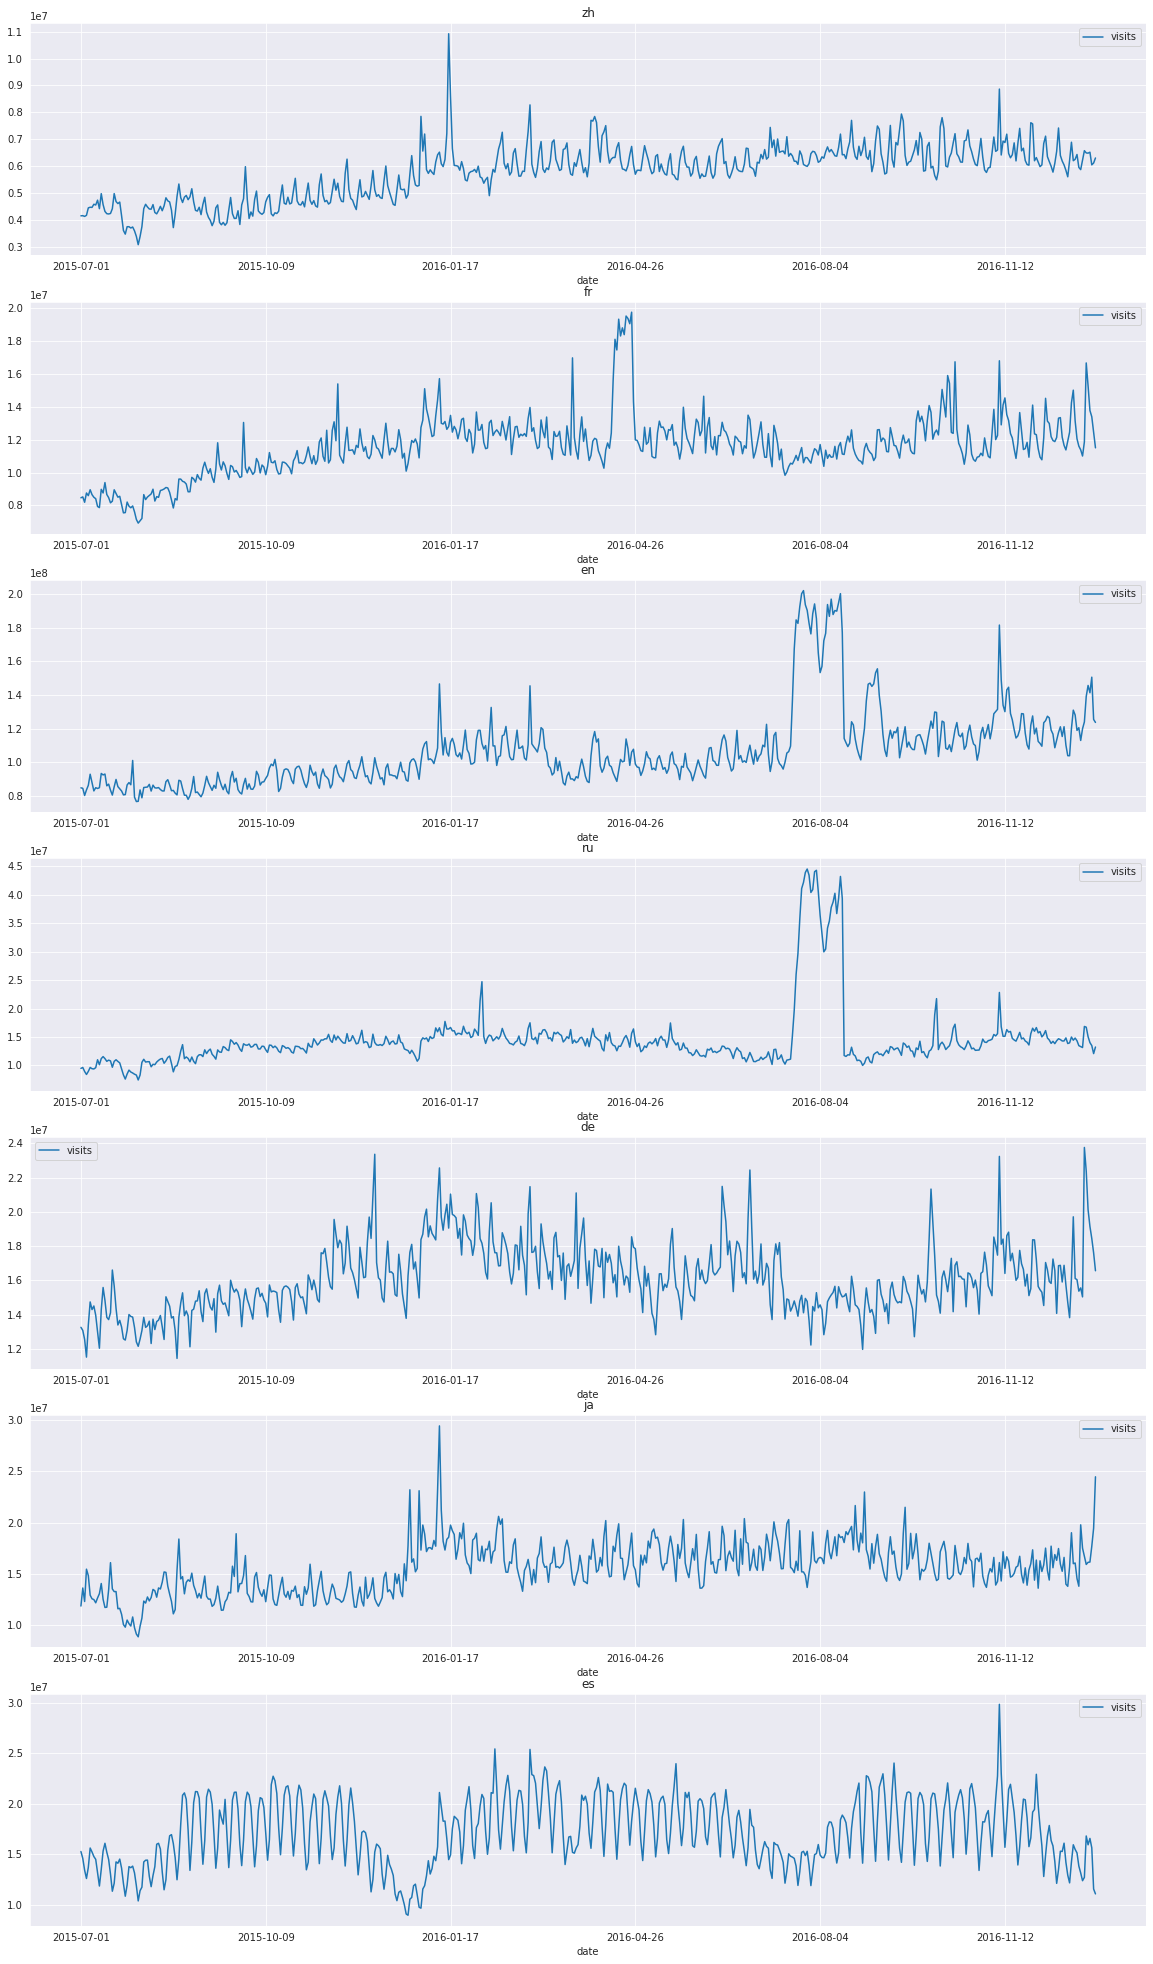

In [31]:
# Now since the datasets are ready for time series analysis, let's plot each time series

fig, axes = plt.subplots(nrows=7, ncols=1)
df_zh.plot(ax=axes[0],figsize=(20,35))
axes[0].set_title('zh')
df_fr.plot(ax=axes[1])
axes[1].set_title('fr')
df_en.plot(ax=axes[2])
axes[2].set_title('en')
df_ru.plot(ax=axes[3])
axes[3].set_title('ru')
df_de.plot(ax=axes[4])
axes[4].set_title('de')
df_ja.plot(ax=axes[5])
axes[5].set_title('ja')
df_es.plot(ax=axes[6])
axes[6].set_title('es')

plt.show()


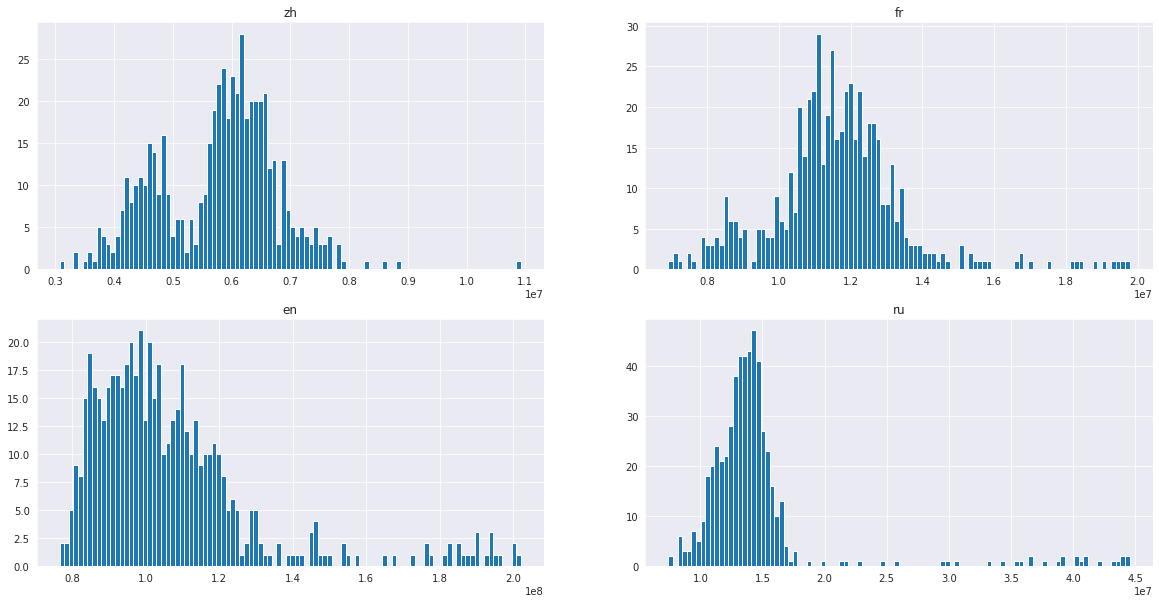

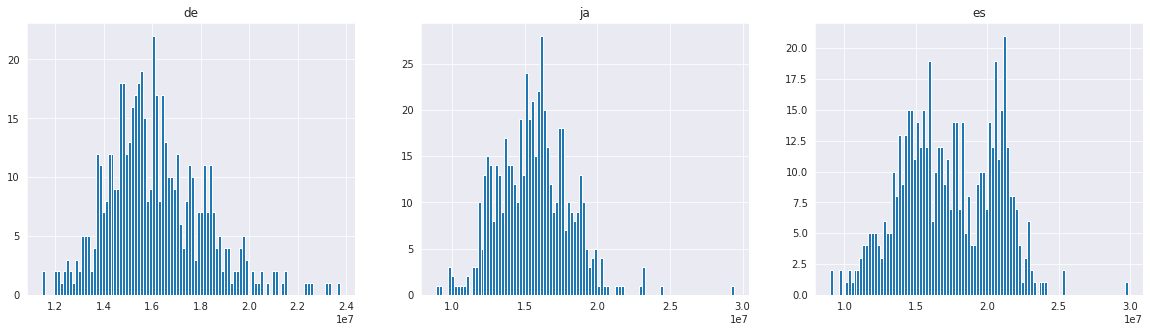

In [32]:
# Let plot the distribution of each time series

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(df_zh,bins=100)
plt.title('zh')
plt.subplot(2,2,2)
plt.hist(df_fr,bins=100)
plt.title('fr')
plt.subplot(2,2,3)
plt.hist(df_en,bins=100)
plt.title('en')
plt.subplot(2,2,4)
plt.hist(df_ru,bins=100)
plt.title('ru')
plt.show()
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(df_de,bins=100)
plt.title('de')
plt.subplot(1,3,2)
plt.hist(df_ja,bins=100)
plt.title('ja')
plt.subplot(1,3,3)
plt.hist(df_es,bins=100)
plt.title('es')
plt.show()

In [33]:
# Code for doing grid search to extract optimum parameters

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df


In [34]:
# We are not doing grid search as it is extremely time consuming and memory exhaustive

#sarimax_gridsearch(train_x.visits, pdq, pdqs, freq='D')

<b>Create pipeline to execute on all languages time series<b>

In [35]:
# Define driver pipeline function which will call other individual functions sequentially

def execute_pipeline(df_zh,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D"):
    adf_test(df_zh.visits)
    func_seasonal_decompose(df_zh.visits, period=period)
    func_acf_pacf_plot(df_zh.visits, lags=49, period=period)
    func_train_test_split(df_zh, cutoff=cutoff)
    func_arima_model_forecast(df_zh, cutoff=cutoff, p=p, d=d, q=q)
    func_sarima_model_forecast(df_zh, cutoff=cutoff, p=p, d=d, q=q, P=P, D=D, Q=Q, S=S)
    func_facebook_prophet_model_forecast(df_zh, cutoff=cutoff, freq=freq)


In [36]:
# Define function to display the performance of the ML model

def performance(actual, predicted):
    print('\033[1mMAE  : \033[1m', round(mae(actual, predicted), 3))
    print('\033[1mRMSE : \033[1m', round(mse(actual, predicted)**0.5, 3)) 
    print('\033[1mMAPE : \033[1m', round(mape(actual, predicted), 3))

In [37]:
# Define function to perform Dicky-Fuller test to check stationarity of the time series

def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('\033[1mSequence is stationary...\033[1m')
    else:
        print('\033[1mSequence is not stationary...\033[1m')
        

In [38]:
# Define function to decompose the original time series into trend, seasonal and residual components

def func_seasonal_decompose(data, period=7):
    print('\033[1mSeasonal decomposition starts... \033[1m')
    model = sm.tsa.seasonal_decompose(data, model='additive', period=period)
    
    print('\033[1mDecomposed time series...\033[1m')
    plt.rcParams['figure.figsize']=(20,10)
    model.plot()
    plt.show()
    
    print('\033[1mResidual plot from decomposed time series...\033[1m')
    print('\033[1mDicky Fuller test for residual from decomposed time series...\033[1m')
    adf_test(model.resid.dropna())

    plt.figure(figsize=(20,5))
    model.resid.plot()
    plt.show()

    print('\033[1mTrend plot from decomposed time series...\033[1m')
    plt.figure(figsize=(20,5))
    model.trend.plot()
    plt.show()

    print('\033[1mPerforming first degree differencing on original time series...\033[1m')
    print('\033[1mDicky Fuller test on differentiated time series...\033[1m')
    adf_test(data.diff(1).dropna())
    plt.figure(figsize=(20,5))
    data.diff(1).plot()
    plt.show()

    print('-'*100)
    print()

In [39]:
# Define function to plot acf and pacf plots for raw time series and seasonal component of the series

def func_acf_pacf_plot(data, lags=49, period=7):
    
    print('\033[1mCreating seasonal decompose model for time series... \033[1m')
    model = sm.tsa.seasonal_decompose(data, model='additive', period=period)
    
    print('\033[1mPacf plot on time series...\033[1m')
    plt.rcParams['figure.figsize'] = (20,5)
    plot_pacf(data, lags=lags)
    plt.show()

    print('\033[1mPacf plot on seasonality...\033[1m')
    plot_pacf(model.seasonal.dropna(), lags=lags);
    plt.show()

    print('\033[1mAcf plot on time series...\033[1m')
    plot_acf(df_zh.visits, lags=lags)
    plt.show()

    print('\033[1mAcf plot on seasonality...\033[1m')
    plot_acf(model.seasonal.dropna(), lags=lags)
    plt.show()
    print('-'*100)
    print()

In [40]:
# Define a function to perform the train test split on the original time series
# Also perform the single degree differencing on the train data and verify the stationarity

def func_train_test_split(data, cutoff=184):
    
    print('\033[1mSplitting time series data into train and test... \033[1m')
    train_x = data[:-cutoff].copy()
    test_x  = data[-cutoff:].copy()

    print('\033[1mShape of train and test data...\033[1m')
    print('\033[1mTrain shape\033[1m: ', train_x.shape)
    print('\033[1mTest shape\033[1m : ', test_x.shape)

    print('\033[1mMaking the train time series stationary...\033[1m')
    train_x_st = train_x.copy()
    train_x_st.visits = train_x_st.visits.diff(1)
    train_x_st.dropna(inplace=True)
    
    print('\033[1mPerform Dicky Fuller test to see if the train series has been made stationary...\033[1m')
    adf_test(train_x_st.visits)
    print('-'*100)
    print()

In [41]:
# Define function to build, train and predict the time series forecast based on ARIMA model

def func_arima_model_forecast(data, cutoff=184, p=7, d=1, q=8):
    
    print('\033[1mARIMA model forecasting... \033[1m')
    print('\033[1mSplitting time series data into train and test...\033[1m')
    train_x = data[:-cutoff].copy()
    test_x  = data[-cutoff:].copy()
    
    print('\033[1mBuilding and traing the model...\033[1m')
    model = SARIMAX(train_x.visits, order=(p, d, q)) 
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=cutoff)
    test_x['visits'].plot(style='-')
    test_x['pred'].plot(style='-')
    plt.show()
    
    print('\033[1mPerformance of the model as below...\033[1m')
    performance(test_x['visits'], test_x['pred'])
    print('-'*100)
    print()

In [42]:
# Define function to build, train and predict the time series forecast based on SARIMA model

def func_sarima_model_forecast(data, cutoff=184, p=7, d=1, q=8, P=1, D=1, Q=1, S=9):
    
    print('\033[1mSARIMA model forecasting...\033[1m')
    print('\033[1mSplitting time series data into train and test...\033[1m')
    train_x = data[:-cutoff].copy()
    test_x  = data[-cutoff:].copy()
    
    print('\033[1mBuilding and training the model...\033[1m')
    model = SARIMAX(train_x.visits, order=(p, d, q), seasonal_order=(P,D,Q,S)) 
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=cutoff)
    test_x['visits'].plot(style='-')
    test_x['pred'].plot(style='-')
    plt.show()
    
    print('\033[1mPerformance of the model as below...\033[1m')
    performance(test_x['visits'], test_x['pred'])
    print('-'*100)
    print()

In [43]:
# Define function to build, train and predict the time series forecast based on facebook's prophet model

def func_facebook_prophet_model_forecast(data, cutoff=184, freq="D"):
    
    print('\033[1mFacebook prophet model forecasting...\033[1m')
    print('\033[1mPreparing data in required format for facebook prophet...\033[1m')
    data_fb = data.copy()
    data_fb = data_fb.reset_index().rename(columns={'date':'ds', 'visits':'y'})
    
    print('\033[1mBuilding and training the model...\033[1m')
    m = Prophet()
    m.fit(data_fb[['ds', 'y']][:-cutoff])
    future = m.make_future_dataframe(periods=cutoff, freq=freq)
    forecast = m.predict(future)
    #print(forecast.head())
    forecast = forecast[['ds','yhat']]
    forecast['y'] = data_fb['y']
    forecast = forecast.set_index('ds')
    #print(forecast.head())
    plt.figure(figsize=(20,5))
    forecast['y'].plot(style='-')
    forecast['yhat'].plot(style='-')
    plt.show()

    print('\033[1mPerformance of the model as below...\033[1m')
    performance(data_fb['y'][:-cutoff],forecast['yhat'][:-cutoff])

    print('-'*100)
    print()
    

<b>Execute the forecast pipeline for zh<b>

Sequence is not stationary...
Seasonal decomposition starts... 
Decomposed time series...


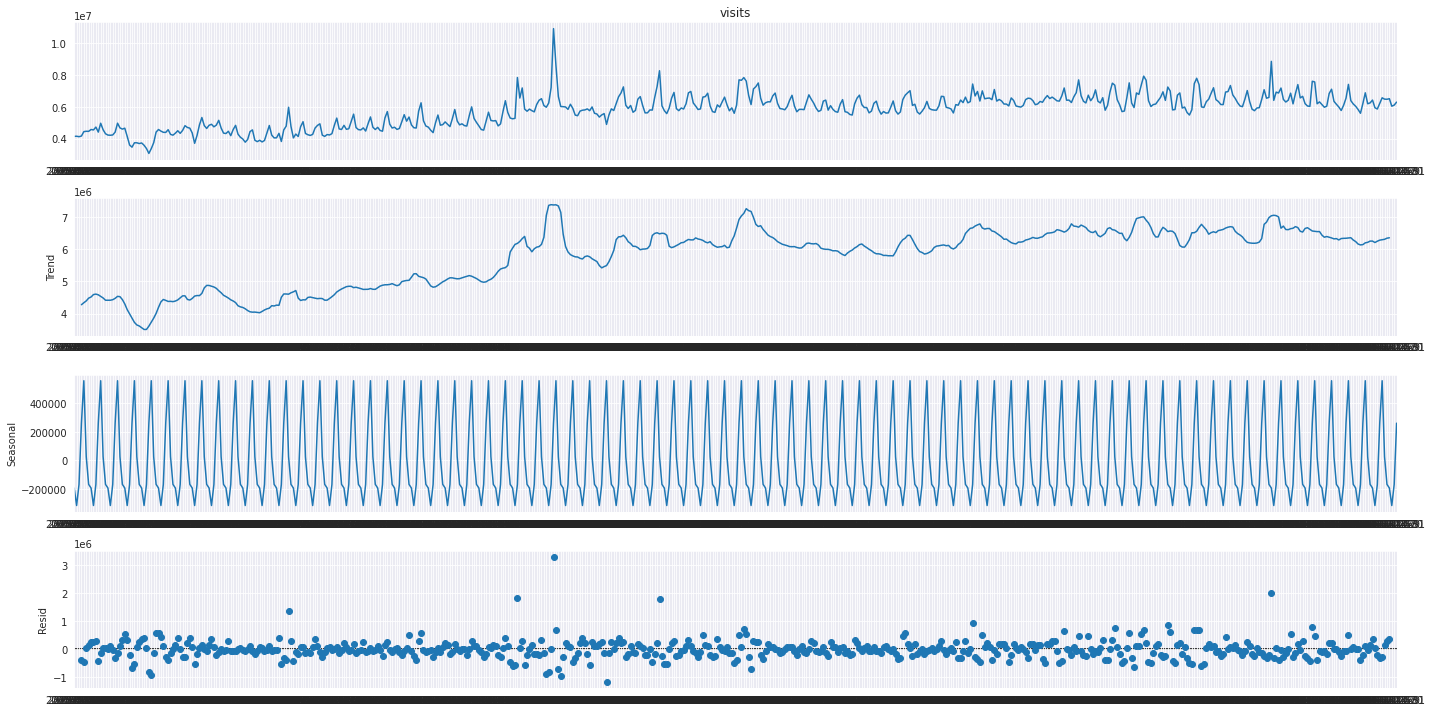

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


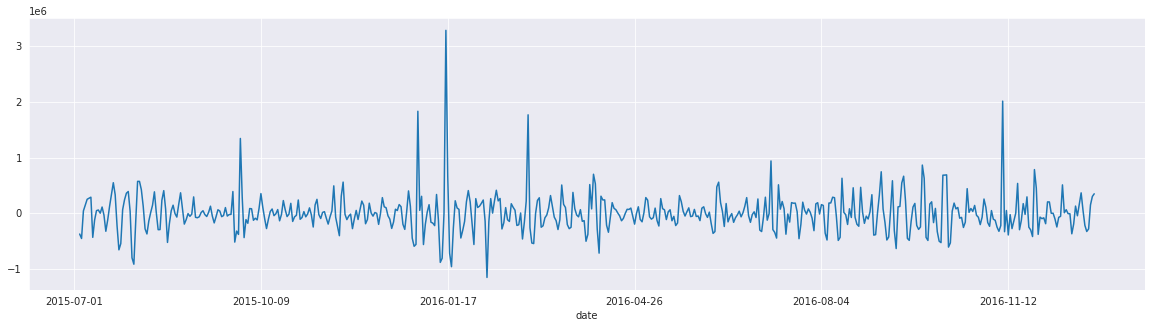

Trend plot from decomposed time series...


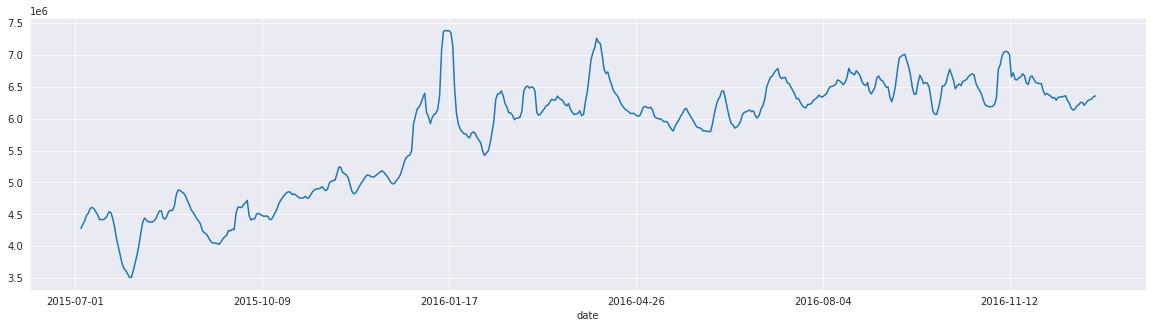

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


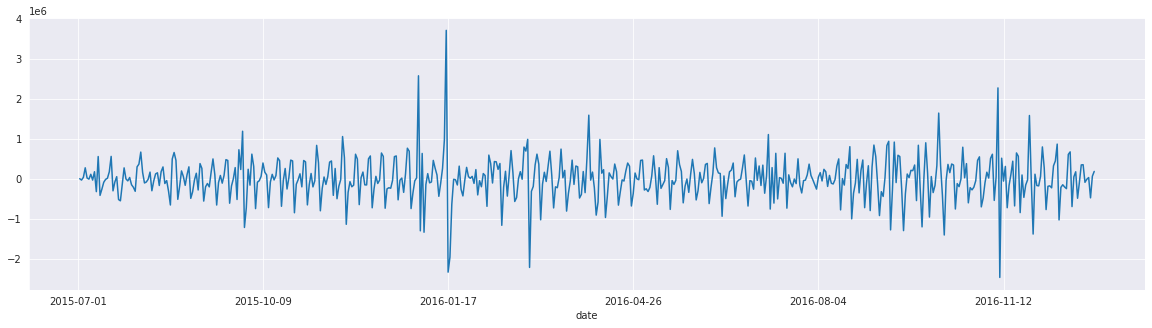

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


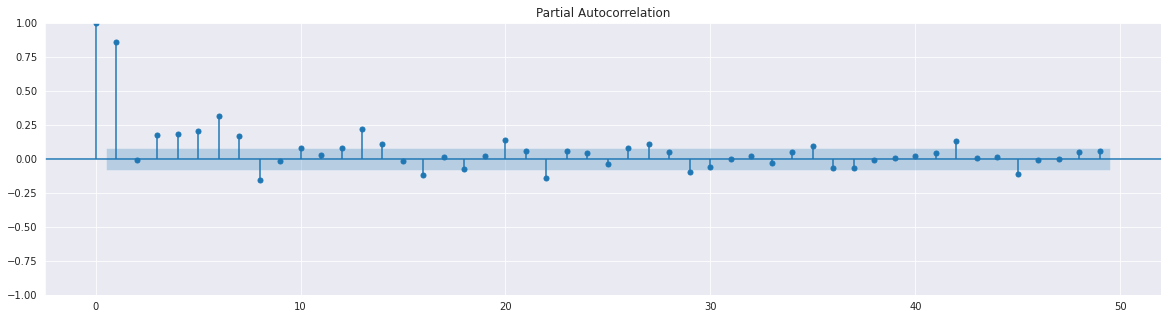

Pacf plot on seasonality...


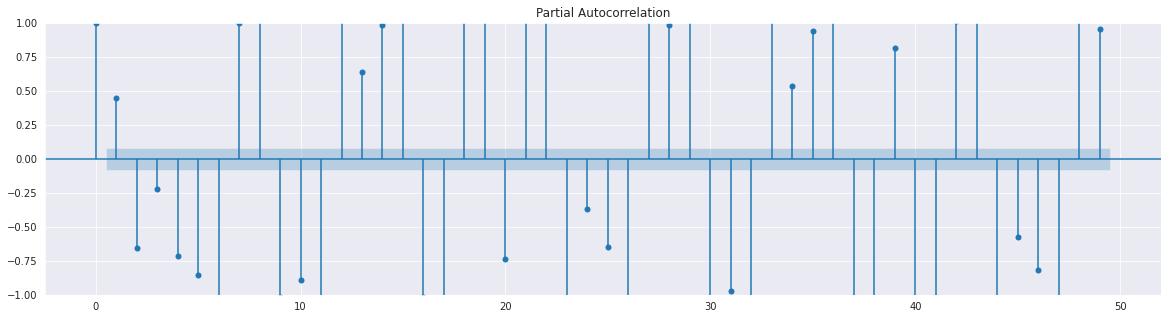

Acf plot on time series...


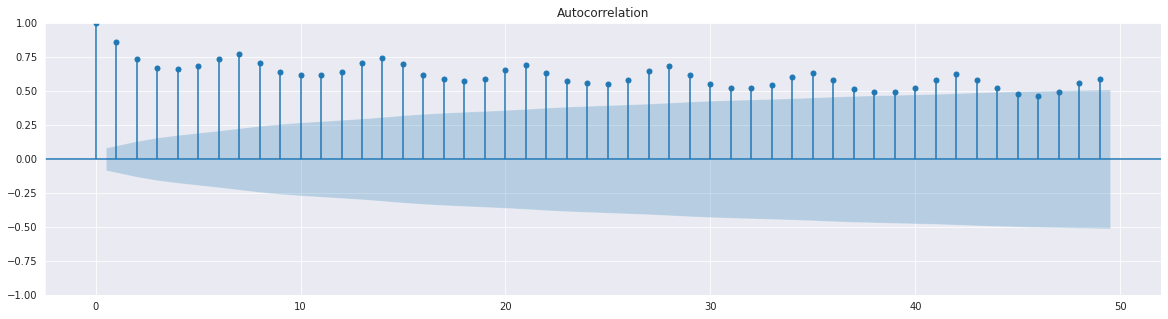

Acf plot on seasonality...


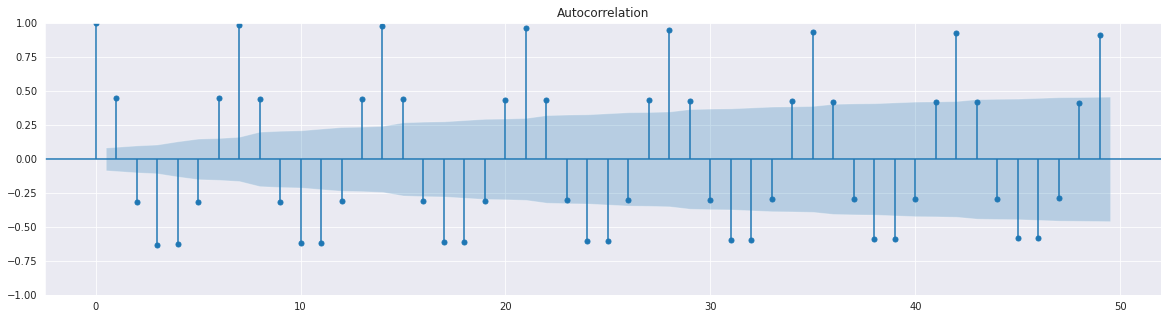

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


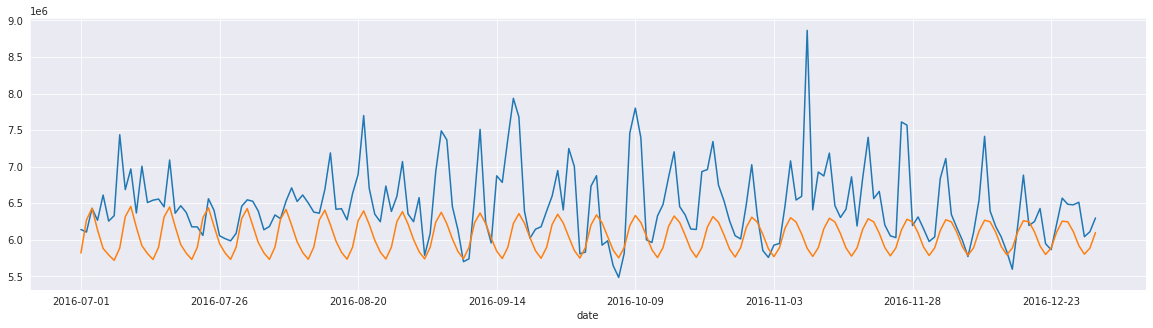

Performance of the model as below...
MAE  :  476092.053
RMSE :  633937.701
MAPE :  0.07
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


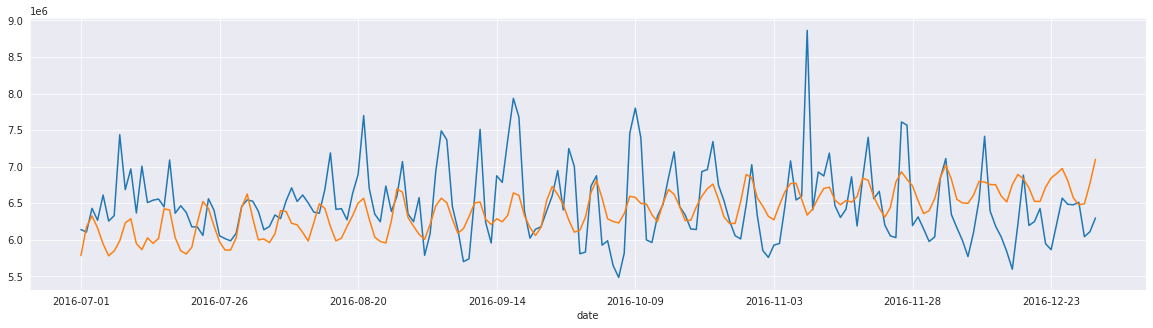

Performance of the model as below...
MAE  :  401699.251
RMSE :  525629.039
MAPE :  0.061
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.2464
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        921.58    0.00299716       87.6074   3.955e-05       0.001      127  LS failed, Hessian reset 
      99       921.874   7.79571e-05       39.9218      0.4543      0.4543      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       922.321   0.000328527       102.155   4.066e-06       0.001      243  LS failed, Hessian reset 
     199       922.549   6.58501e-05       71.5087      0.3481      0.3481      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       922.603   2.88435e-05       63.9773   4.961e-07       0.001      428  LS failed, Hessian reset 
     264       922.607   1.24196e-05       62.3113   2.314e-07       0.001      507  LS failed, Hessian reset 
     299       922.608    5.8132e-08       54.3395      0.4884    

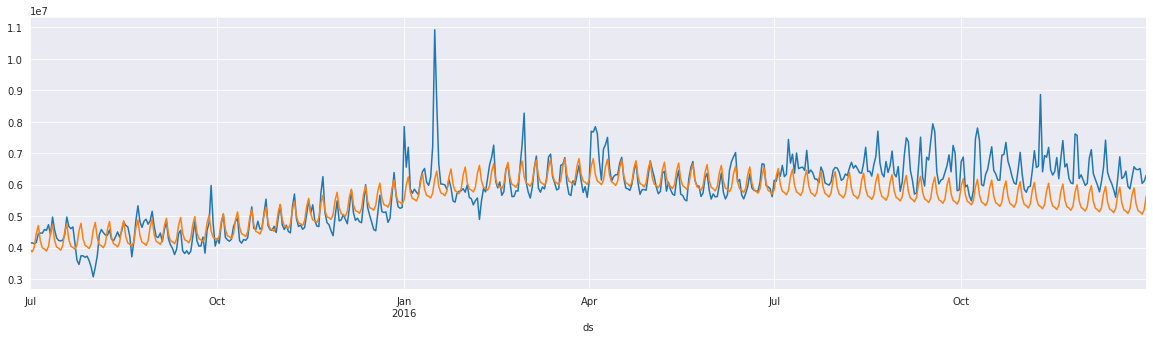

Performance of the model as below...
MAE  :  321854.069
RMSE :  506365.225
MAPE :  0.06
----------------------------------------------------------------------------------------------------



In [44]:
#Execute the pipeline for language zh

execute_pipeline(df_zh,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for fr<b>

Sequence is not stationary...
Seasonal decomposition starts... 
Decomposed time series...


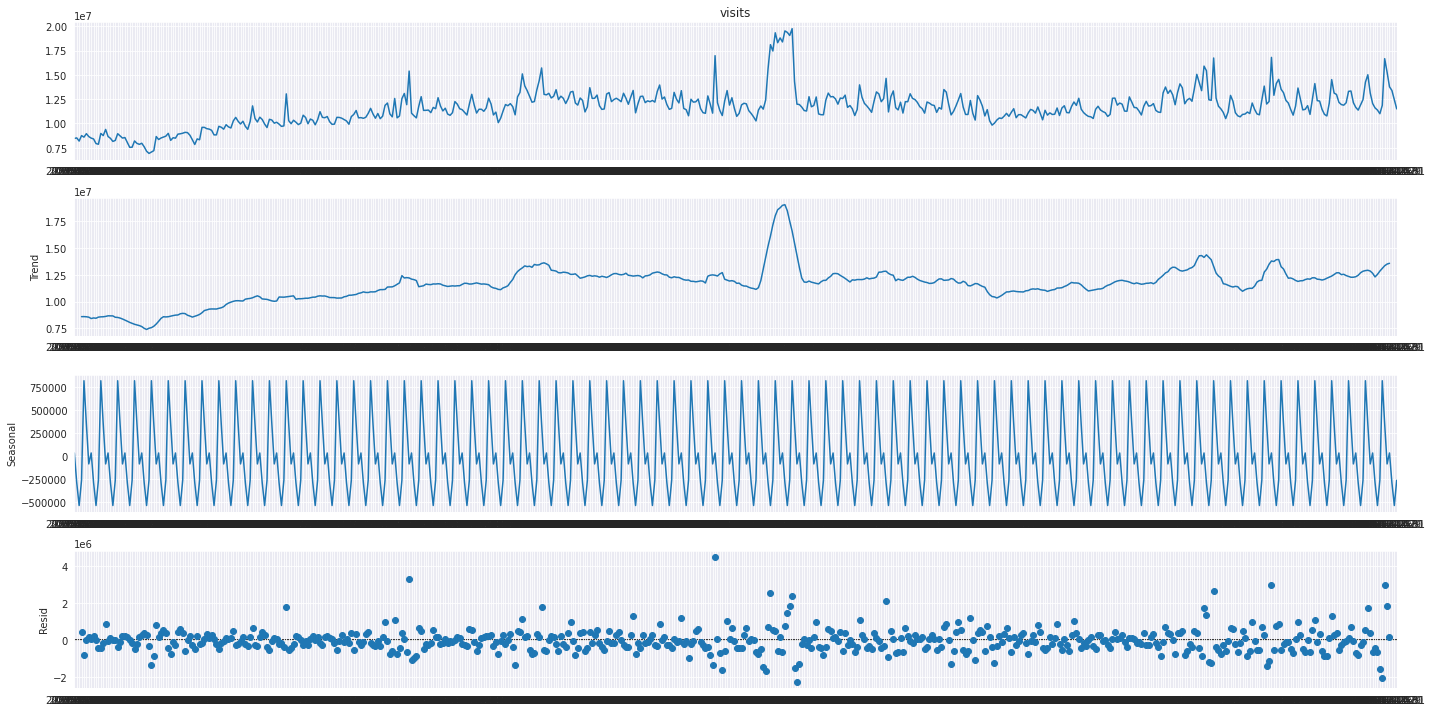

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


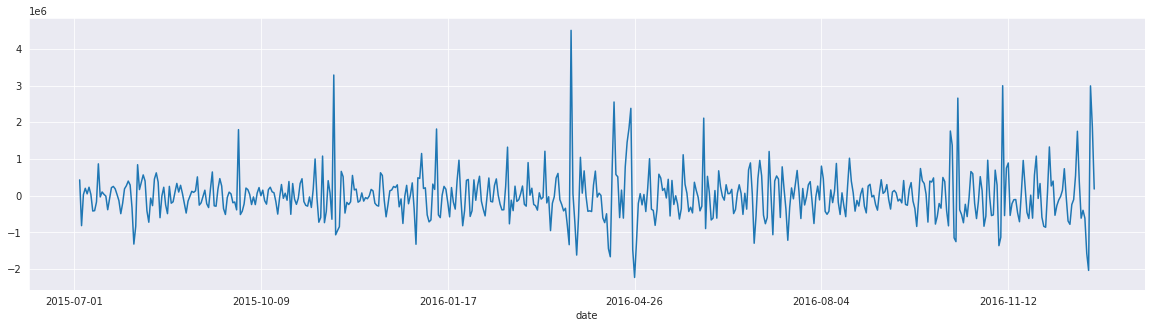

Trend plot from decomposed time series...


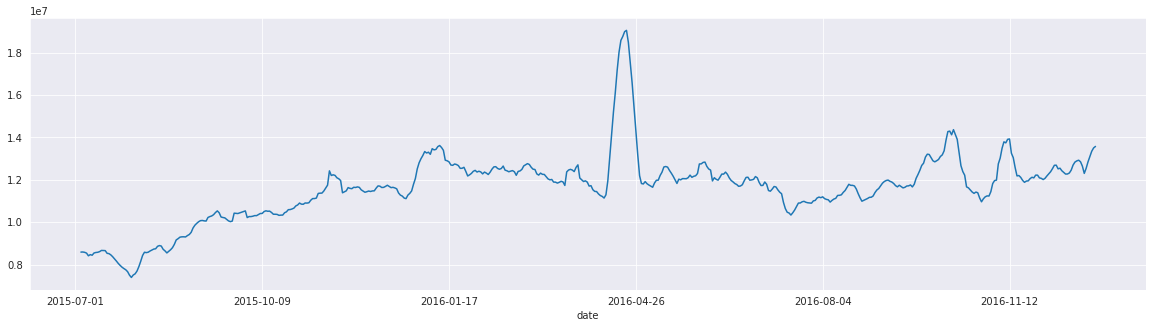

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


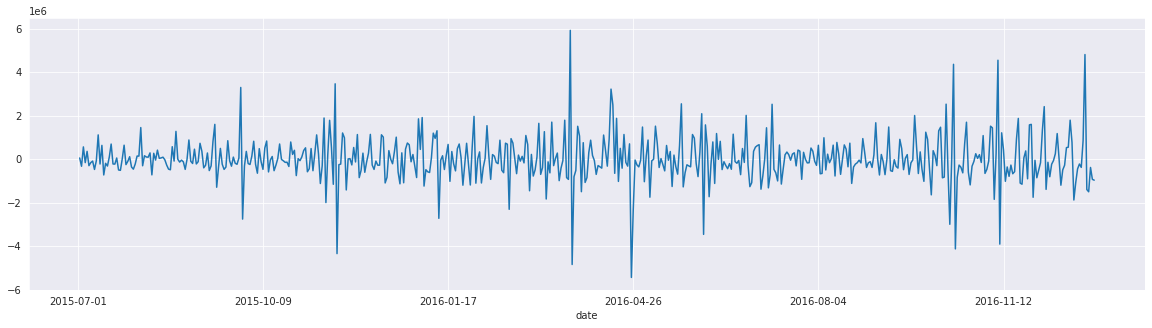

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


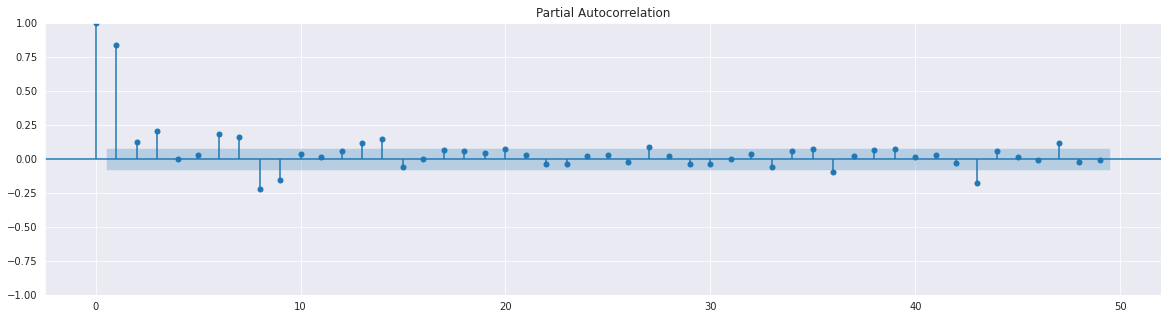

Pacf plot on seasonality...


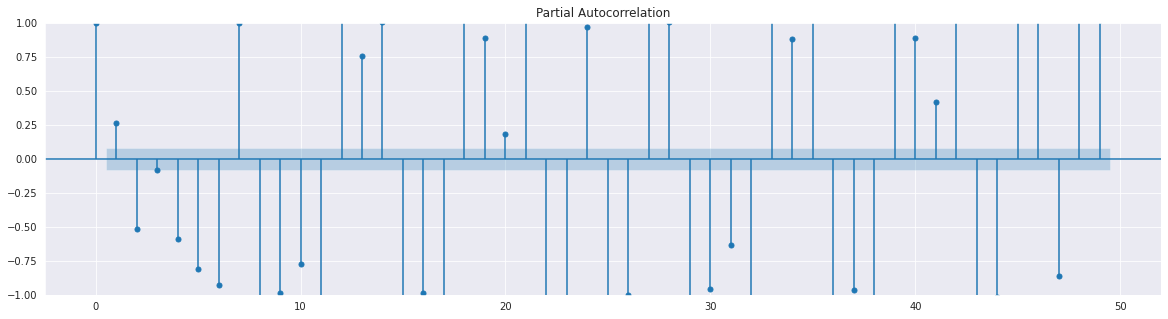

Acf plot on time series...


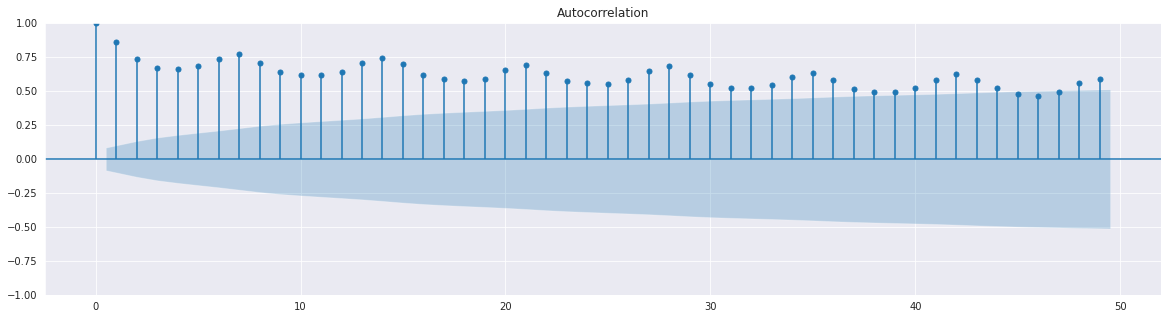

Acf plot on seasonality...


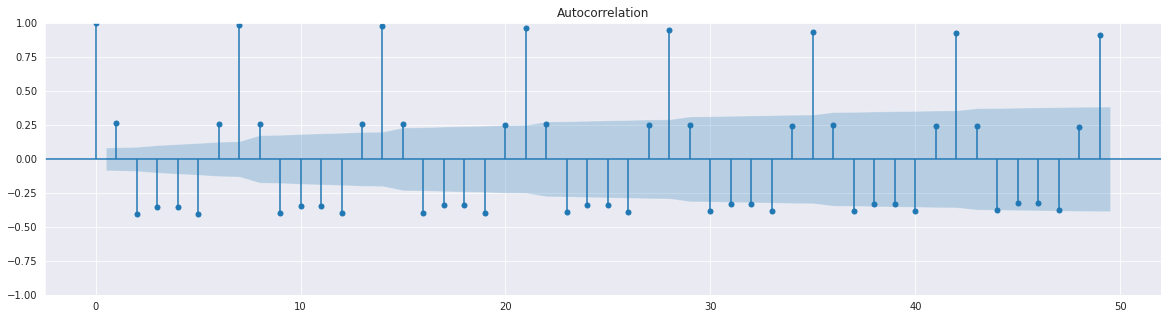

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


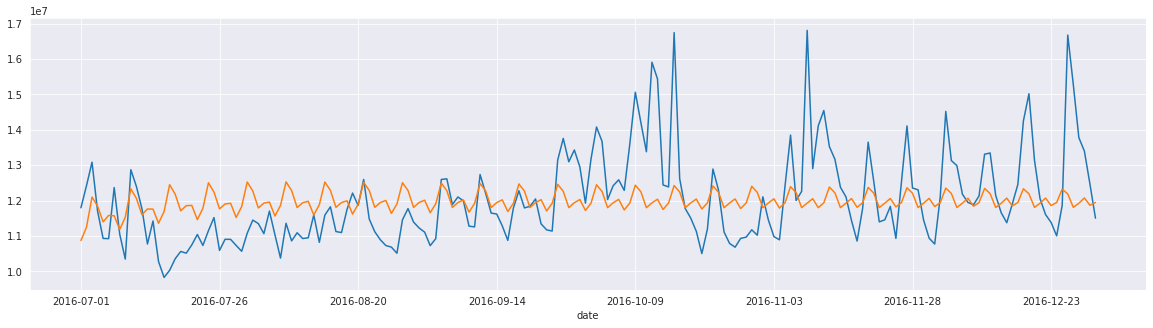

Performance of the model as below...
MAE  :  910017.977
RMSE :  1218343.286
MAPE :  0.074
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


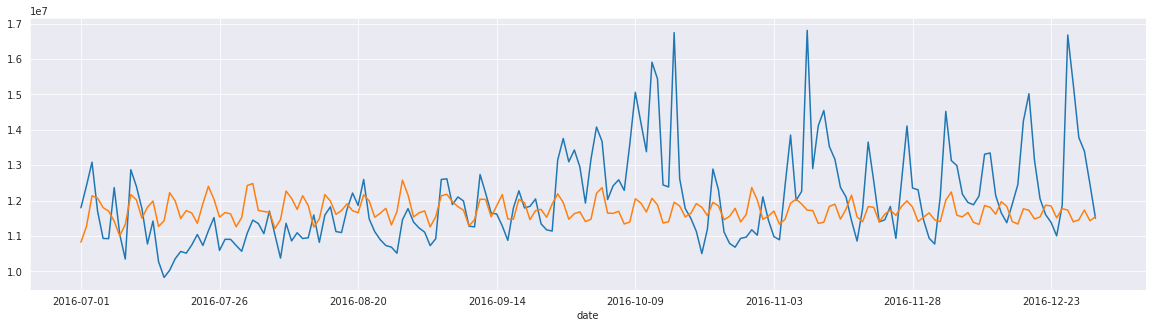

Performance of the model as below...
MAE  :  952073.162
RMSE :  1303201.331
MAPE :  0.075
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.34188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       806.104   2.92549e-05        60.759      0.5309      0.5309      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       806.663     0.0029644       220.786   4.396e-05       0.001      259  LS failed, Hessian reset 
     199       807.059   0.000208733       81.2452           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       807.269   5.97843e-05       50.1286      0.3535           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       807.303   1.85353e-06       80.0913      0.3035           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       807.304   4.04538e-06    

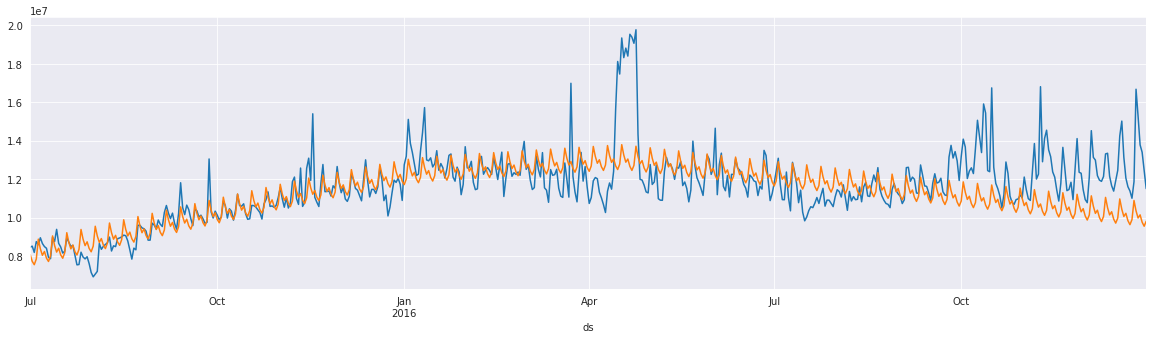

Performance of the model as below...
MAE  :  734377.148
RMSE :  1274683.935
MAPE :  0.06
----------------------------------------------------------------------------------------------------



In [127]:
# Execute the pipeline for language fr

execute_pipeline(df_fr,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for en<b>

Sequence is not stationary...
Seasonal decomposition starts... 
Decomposed time series...


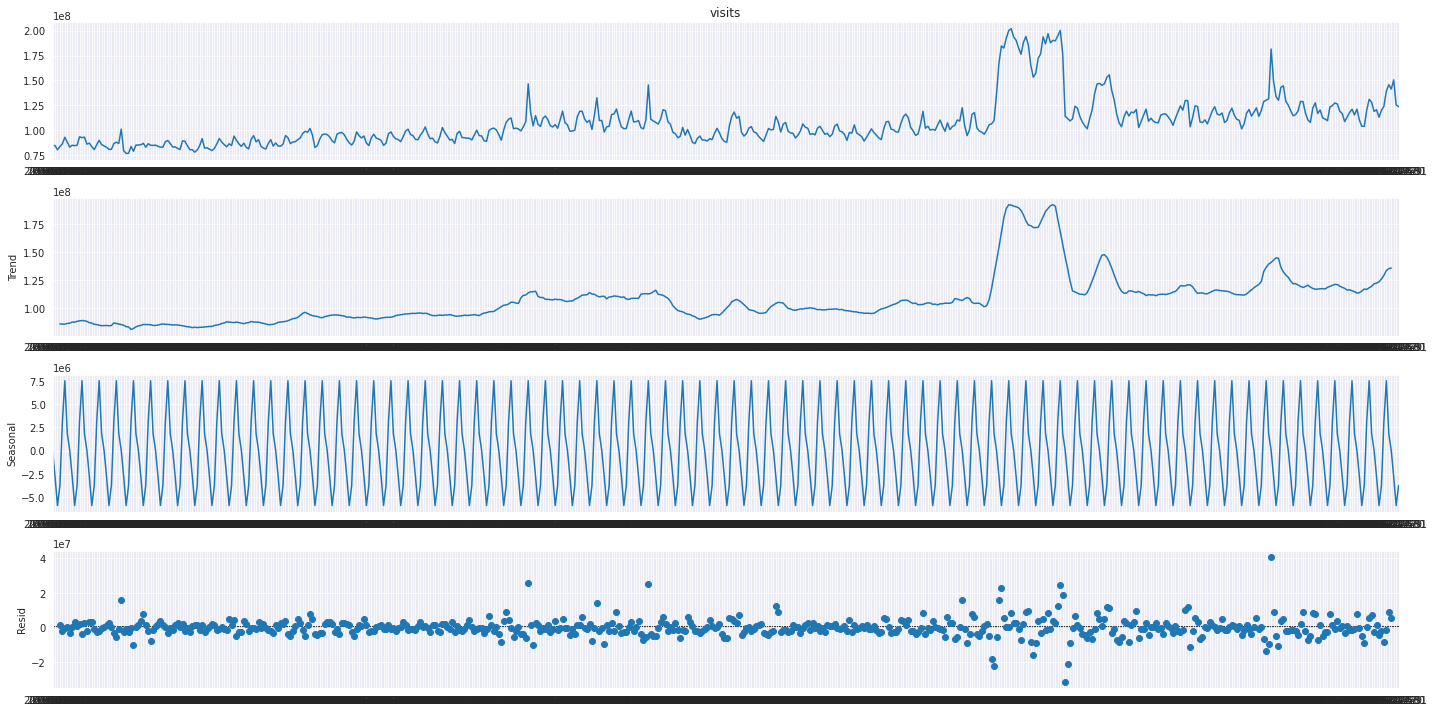

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


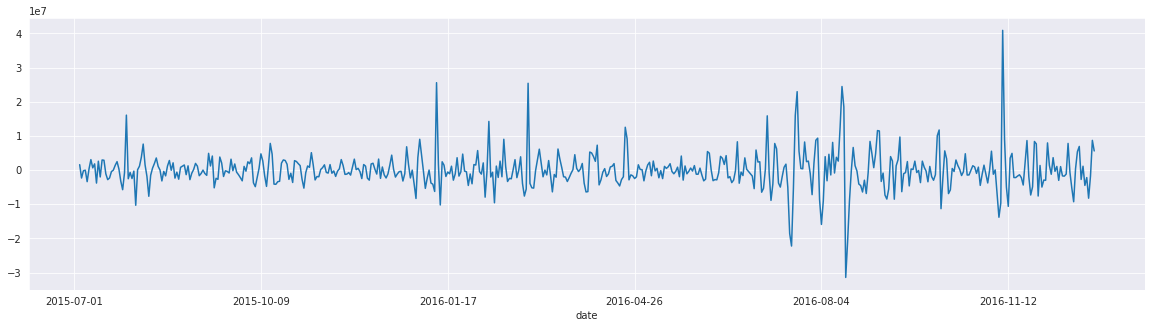

Trend plot from decomposed time series...


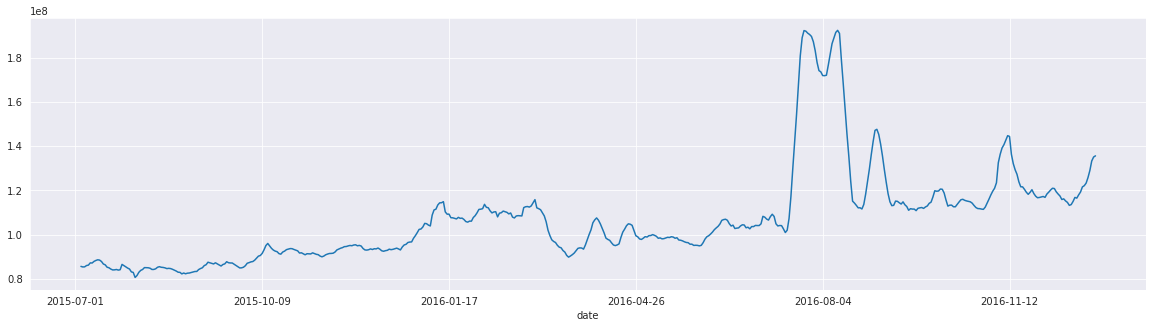

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


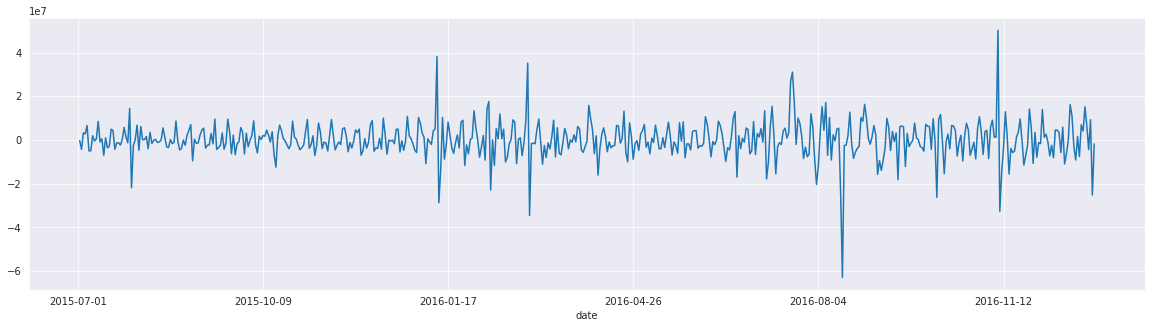

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


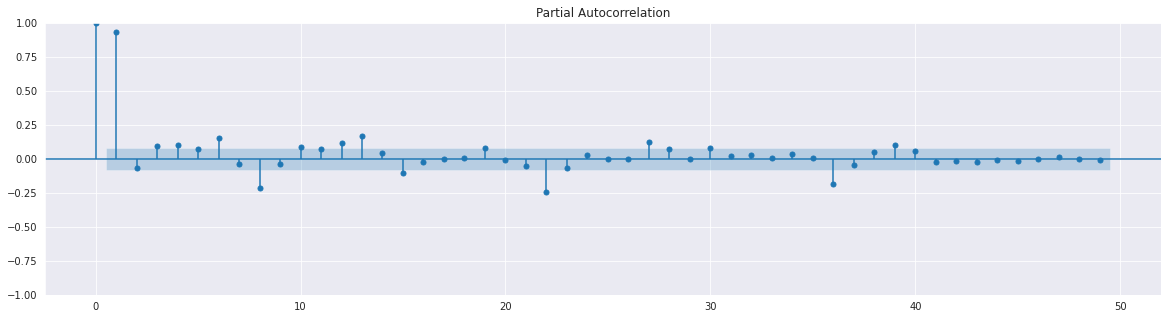

Pacf plot on seasonality...


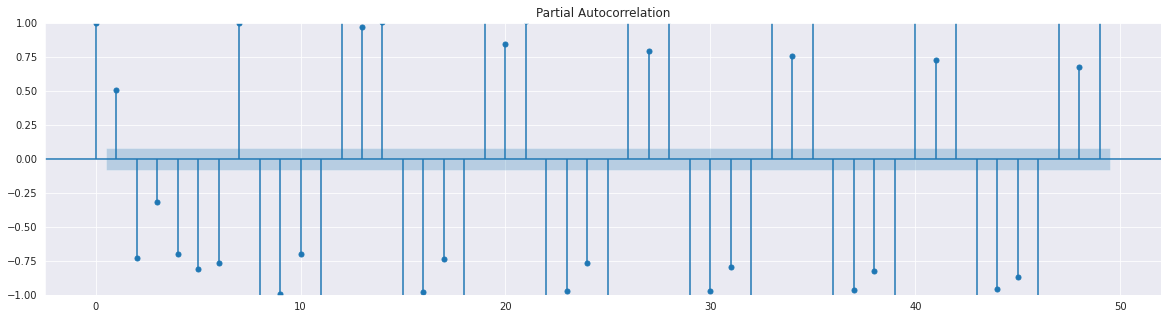

Acf plot on time series...


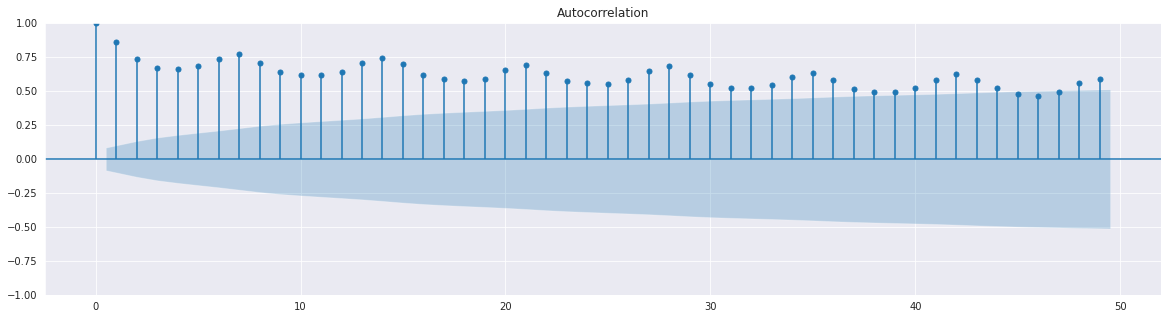

Acf plot on seasonality...


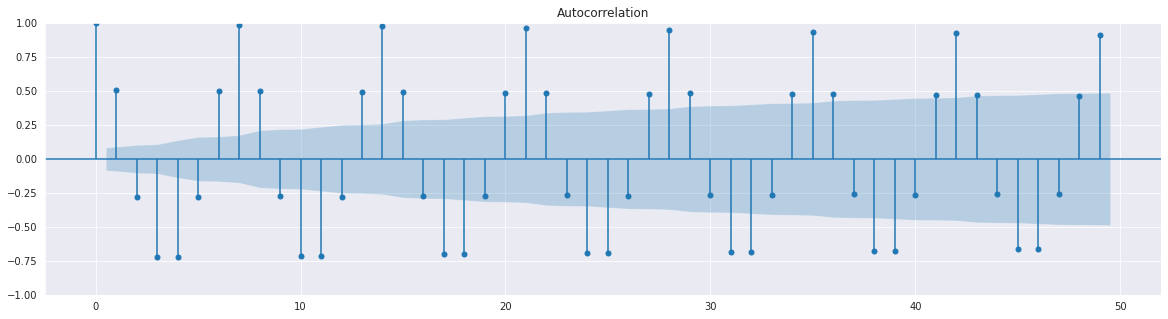

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


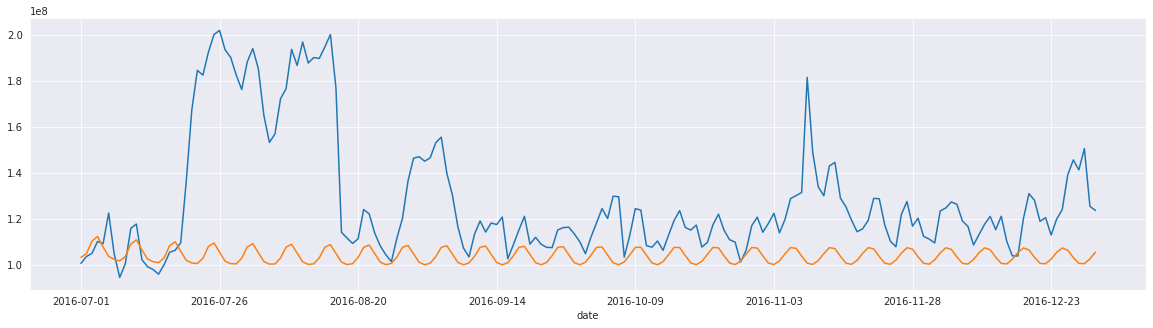

Performance of the model as below...
MAE  :  24883813.422
RMSE :  36120817.997
MAPE :  0.167
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


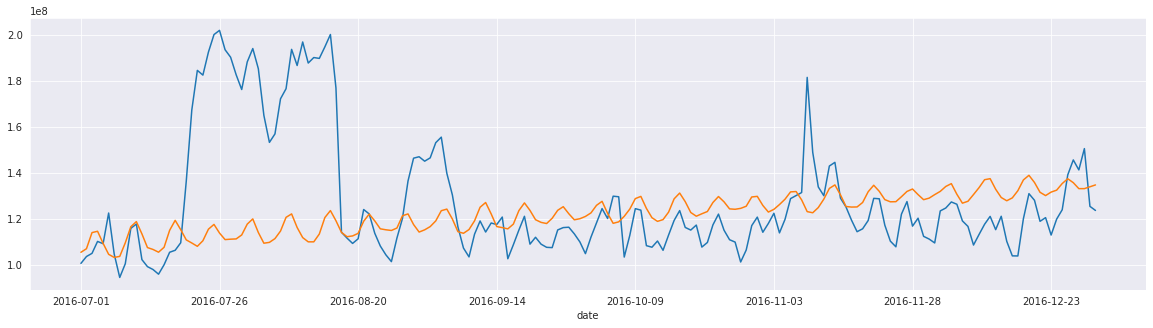

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance of the model as below...
MAE  :  19626432.443
RMSE :  30011543.202
MAPE :  0.134
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...
Initial log joint probability = -2.62077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       974.899   9.16197e-05       49.9046      0.5183      0.5183      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       975.091   0.000361063       114.939   7.372e-06       0.001      197  LS failed, Hessian reset 
     199       975.836   0.000655159       56.8797       0.645       0.645      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       975.854   2.27786e-05       50.9007   5.135e-07       0.0

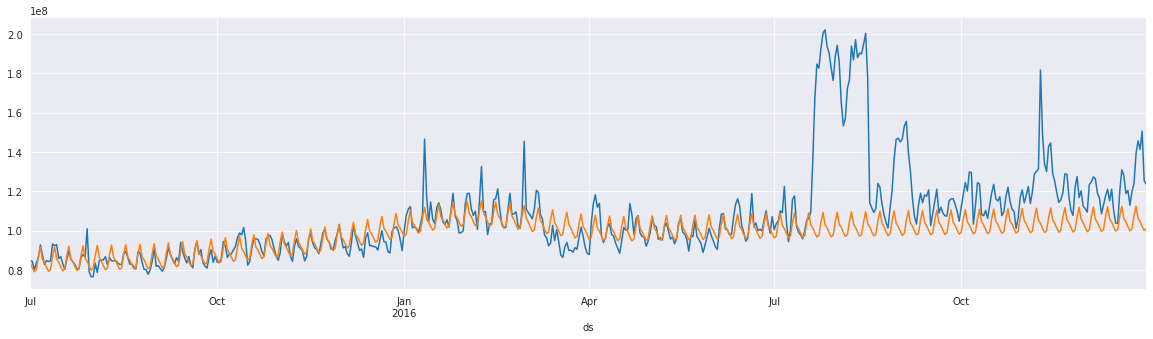

Performance of the model as below...
MAE  :  3896453.137
RMSE :  5585507.844
MAPE :  0.039
----------------------------------------------------------------------------------------------------



In [128]:
# Execute the pipeline for language en

execute_pipeline(df_en,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for ru<b>

Sequence is stationary...
Seasonal decomposition starts... 
Decomposed time series...


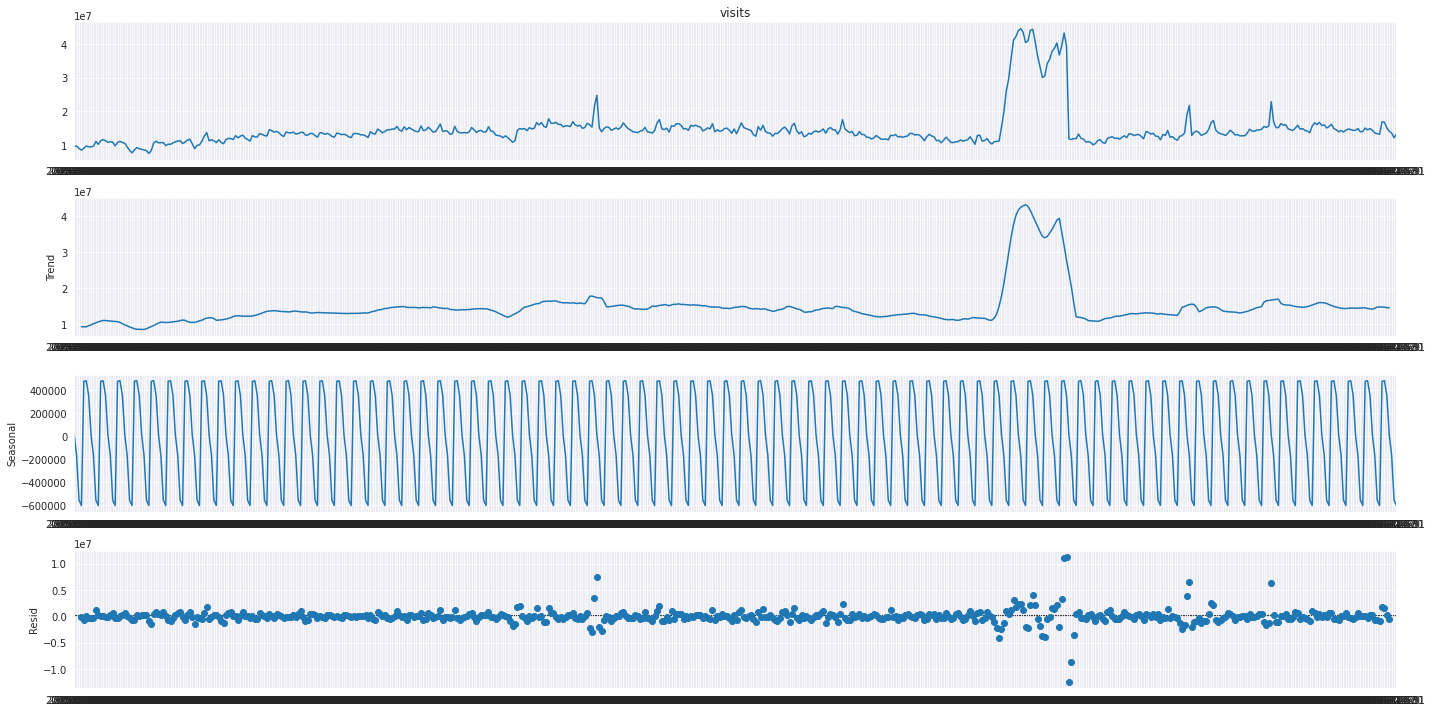

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


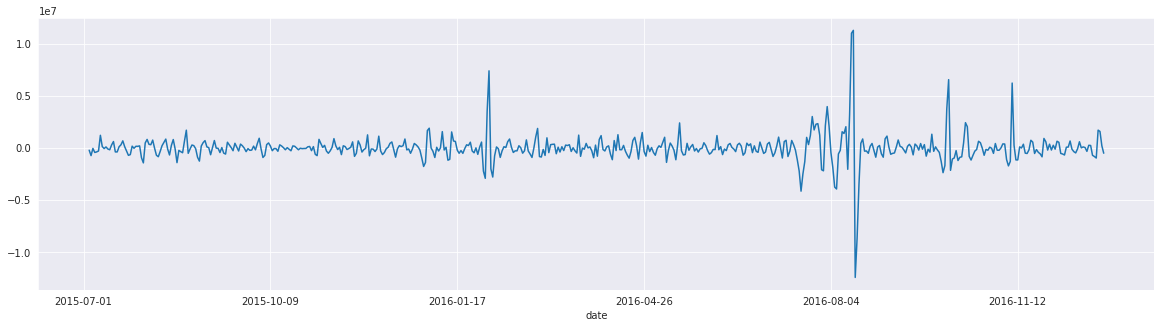

Trend plot from decomposed time series...


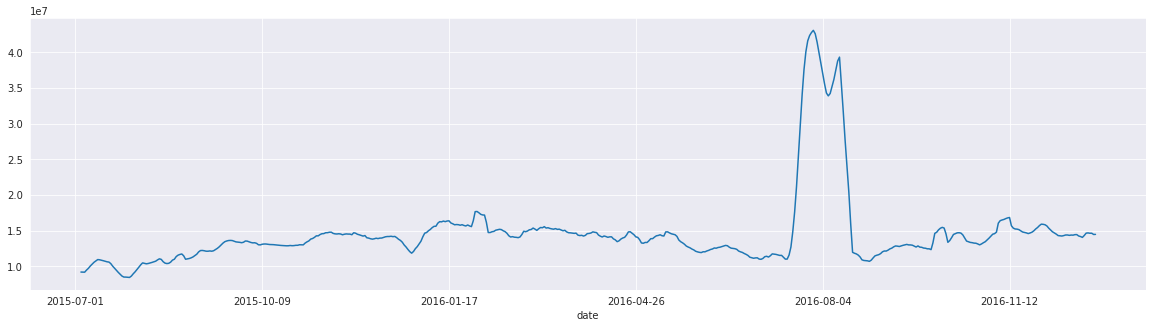

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


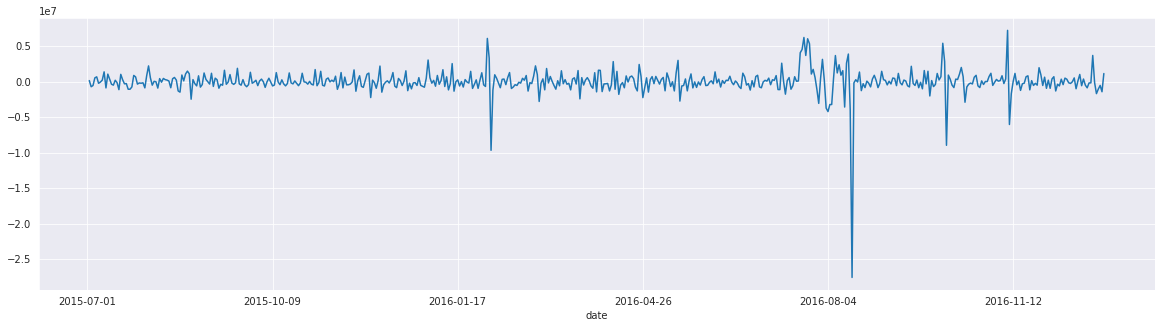

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


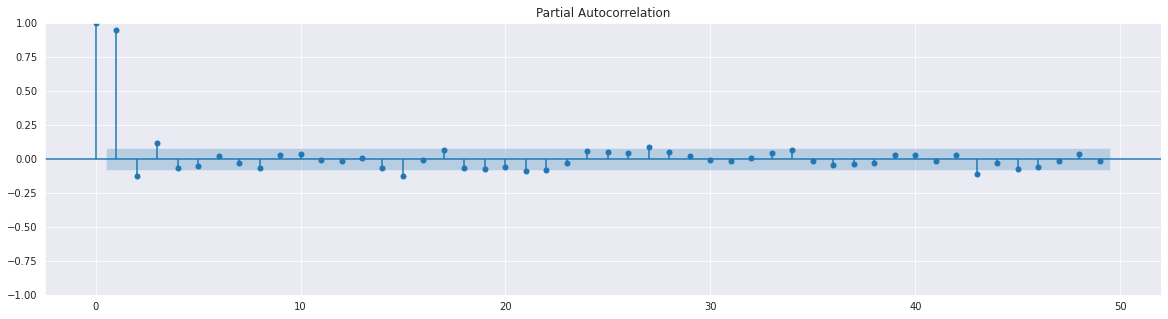

Pacf plot on seasonality...


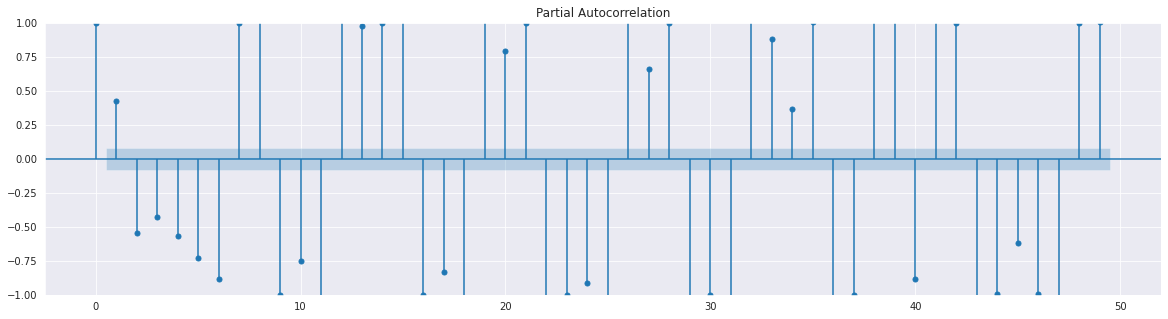

Acf plot on time series...


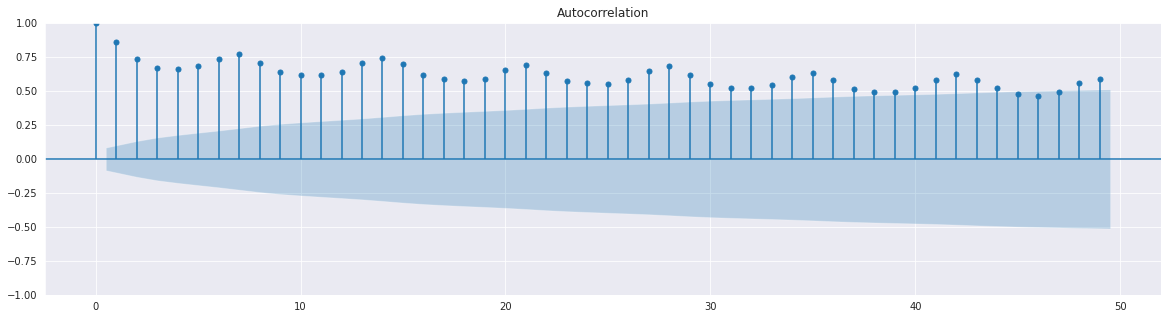

Acf plot on seasonality...


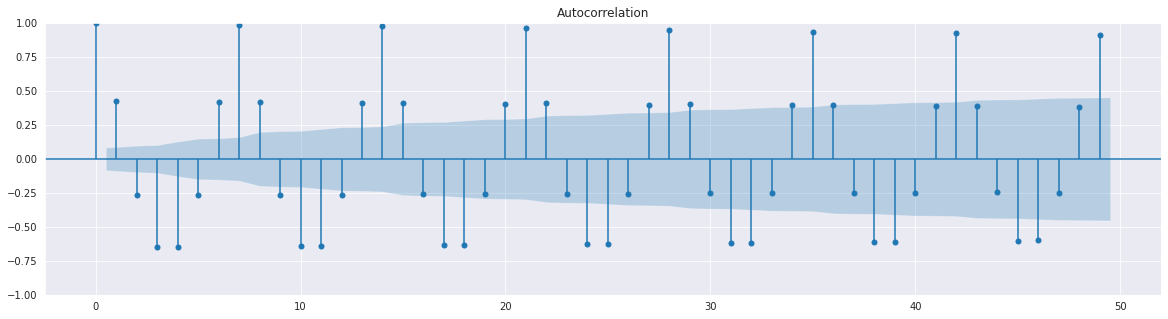

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


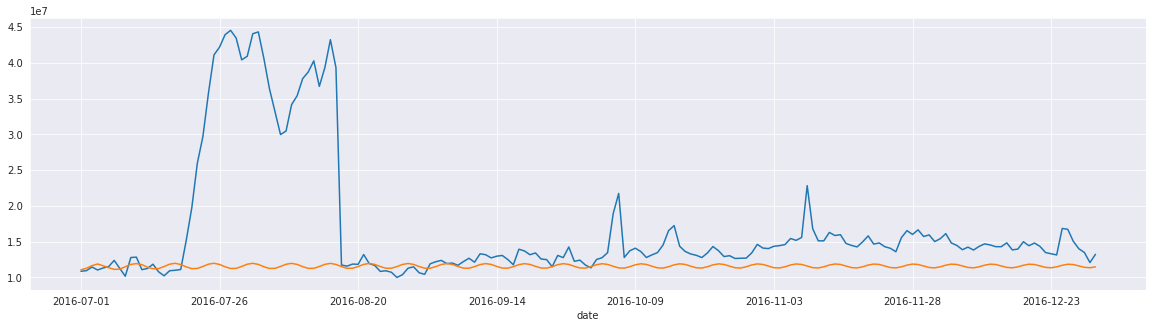

Performance of the model as below...
MAE  :  5607789.457
RMSE :  10481343.405
MAPE :  0.223
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


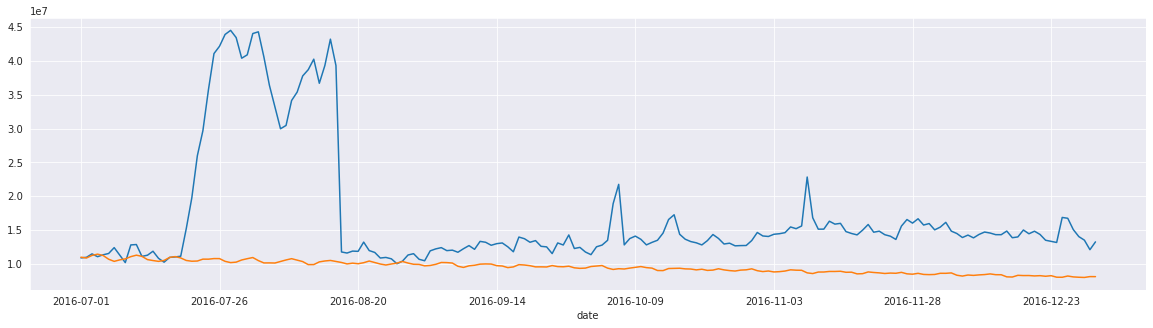

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance of the model as below...
MAE  :  7562858.114
RMSE :  11555305.307
MAPE :  0.354
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...
Initial log joint probability = -6.27818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       930.053   0.000632601       53.9646      0.7032      0.7032      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       930.835    0.00151781       258.857   9.472e-06       0.001      246  LS failed, Hessian reset 
     199       931.299     0.0001335       52.9445       1.874      0.4933      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       931.399   0.000364172       117.596   3.916e-06       0.00

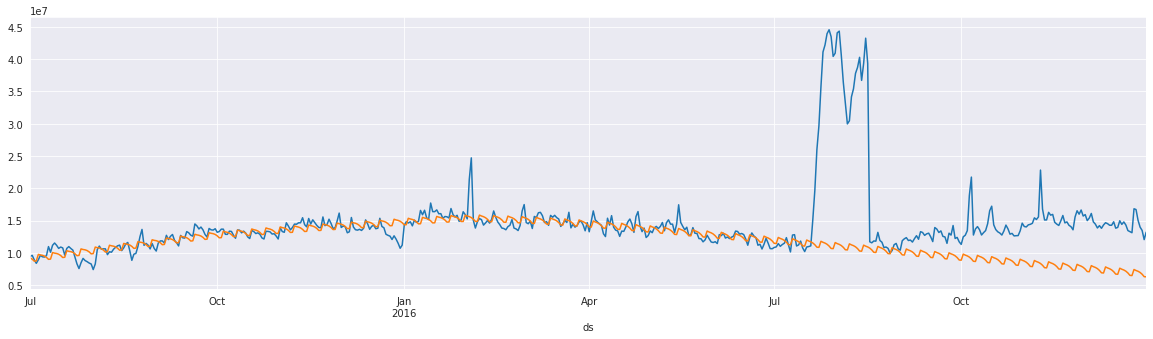

Performance of the model as below...
MAE  :  759925.98
RMSE :  1112824.695
MAPE :  0.059
----------------------------------------------------------------------------------------------------



In [129]:
# Execute the pipeline for language ru

execute_pipeline(df_ru,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for de<b>

Sequence is not stationary...
Seasonal decomposition starts... 
Decomposed time series...


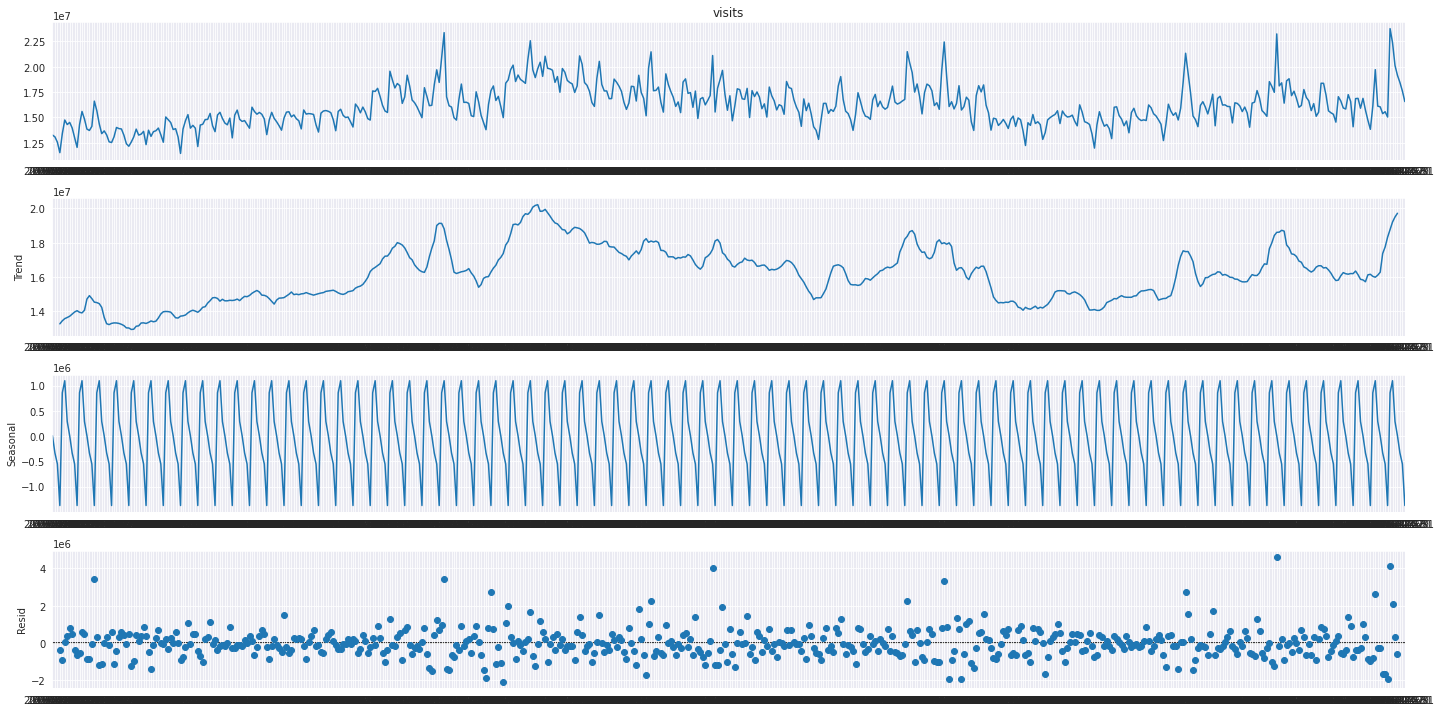

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


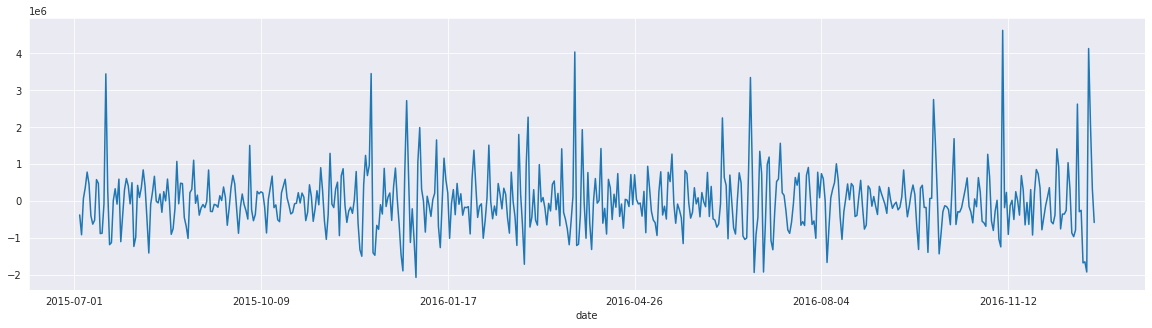

Trend plot from decomposed time series...


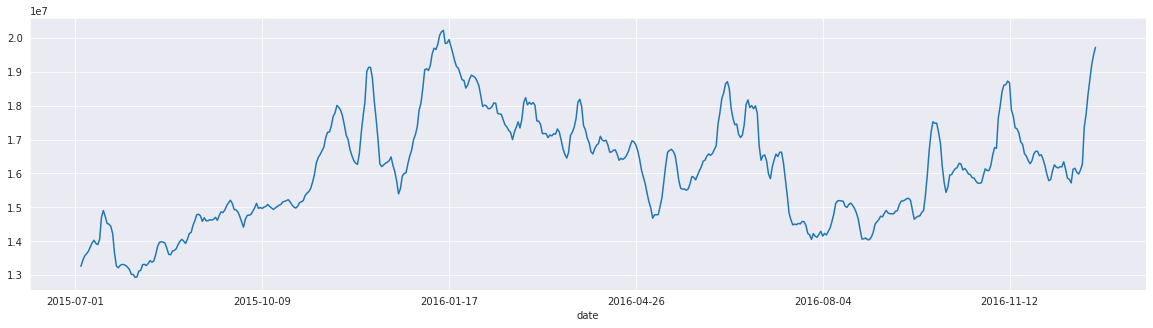

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


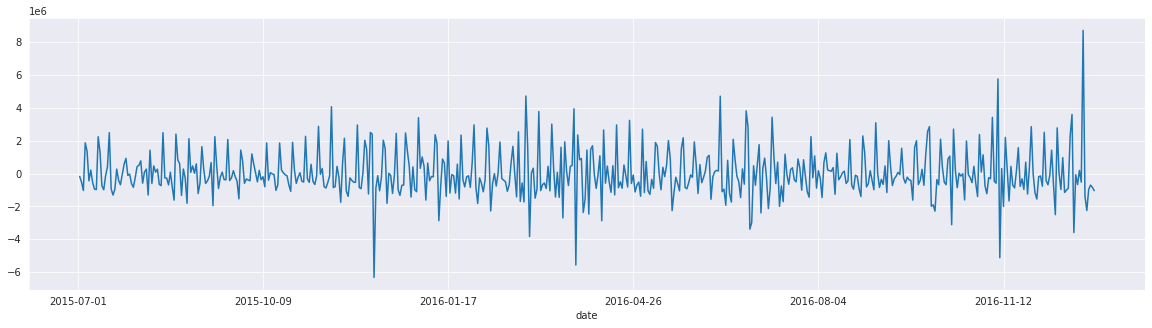

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


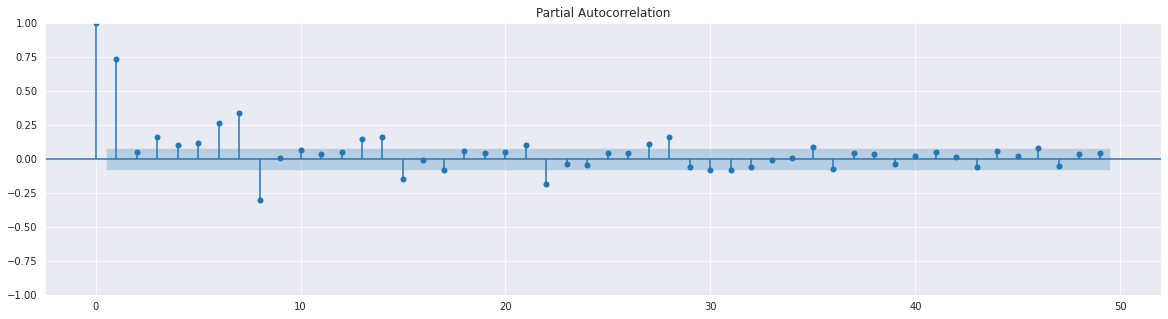

Pacf plot on seasonality...


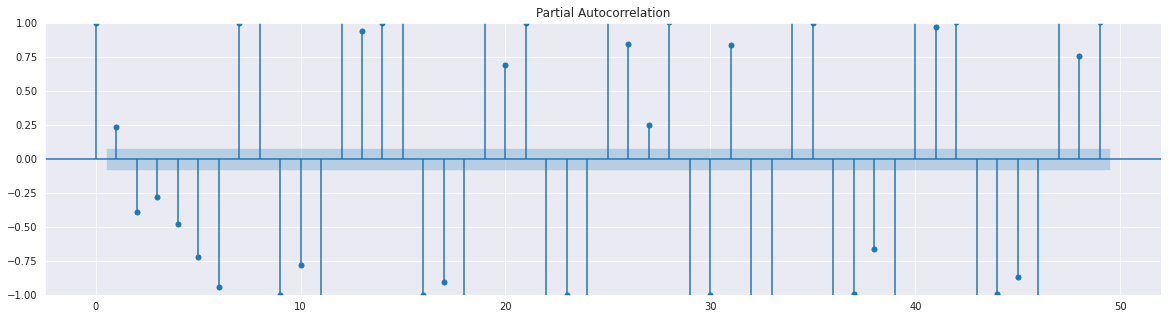

Acf plot on time series...


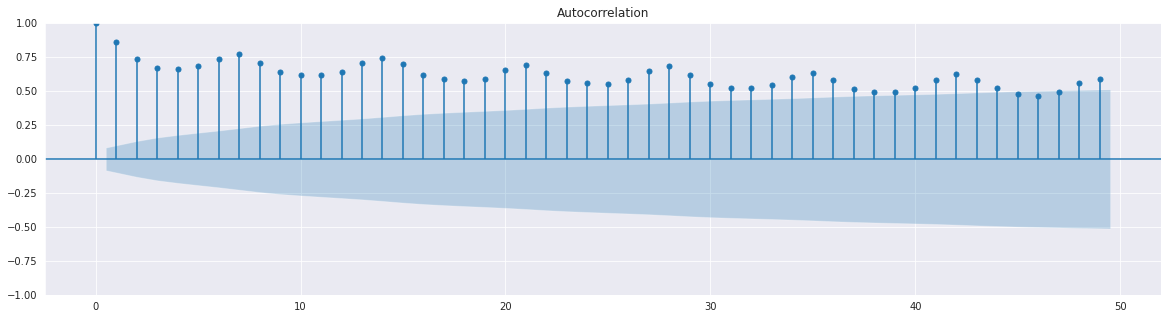

Acf plot on seasonality...


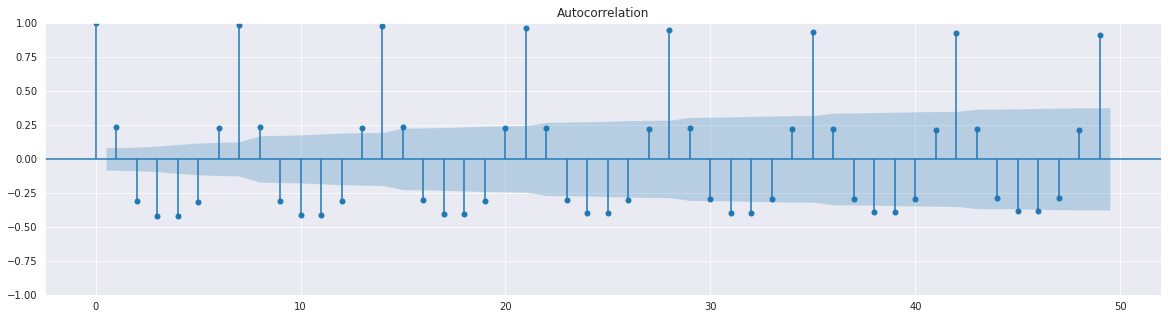

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


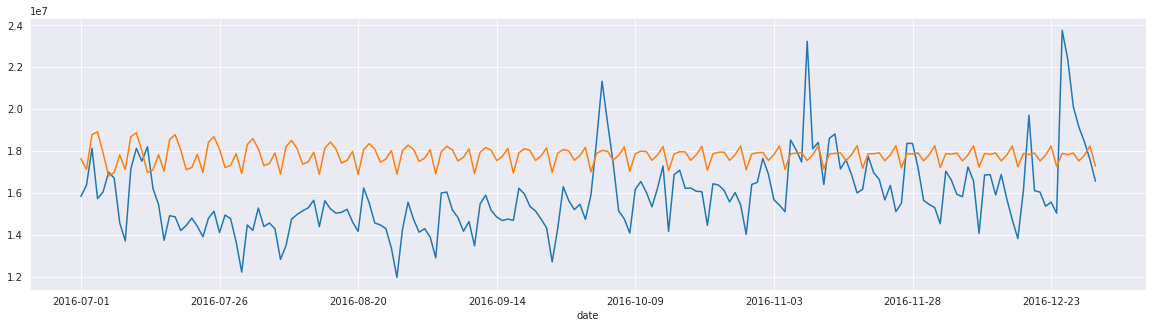

Performance of the model as below...
MAE  :  2281036.647
RMSE :  2580272.367
MAPE :  0.15
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


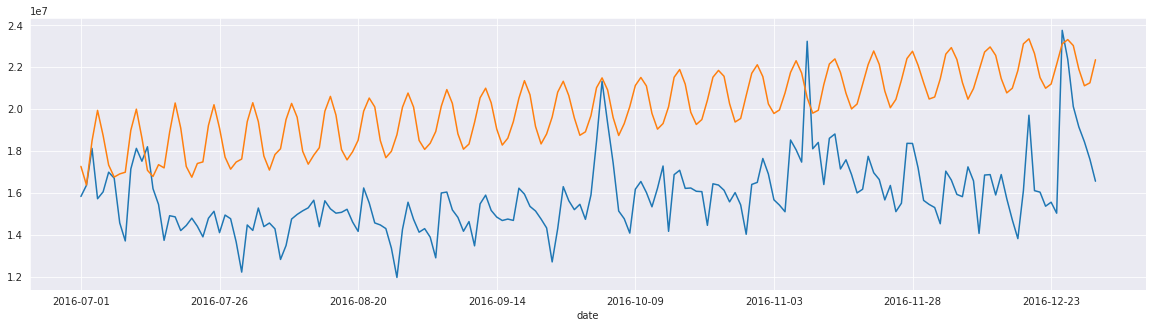

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance of the model as below...
MAE  :  4215109.387
RMSE :  4498310.502
MAPE :  0.273
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...
Initial log joint probability = -3.65976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       887.148    0.00118768       75.3444           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       887.408   0.000267762       97.1864   3.322e-06       0.001      233  LS failed, Hessian reset 
     199       887.579   8.10477e-07       69.8888           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       889.295   0.000260013       76.0945      0.5691      0.5691

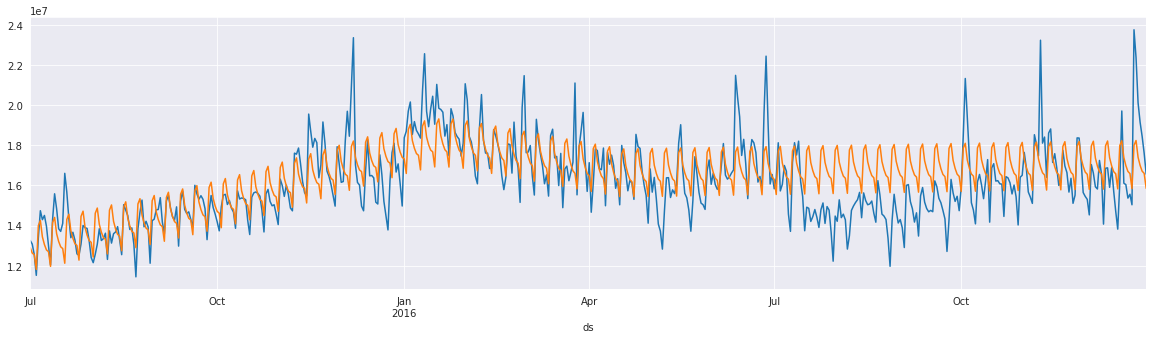

Performance of the model as below...
MAE  :  844039.782
RMSE :  1168803.896
MAPE :  0.051
----------------------------------------------------------------------------------------------------



In [130]:
# Execute the pipeline for language de

execute_pipeline(df_de,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for ja<b>

Sequence is not stationary...
Seasonal decomposition starts... 
Decomposed time series...


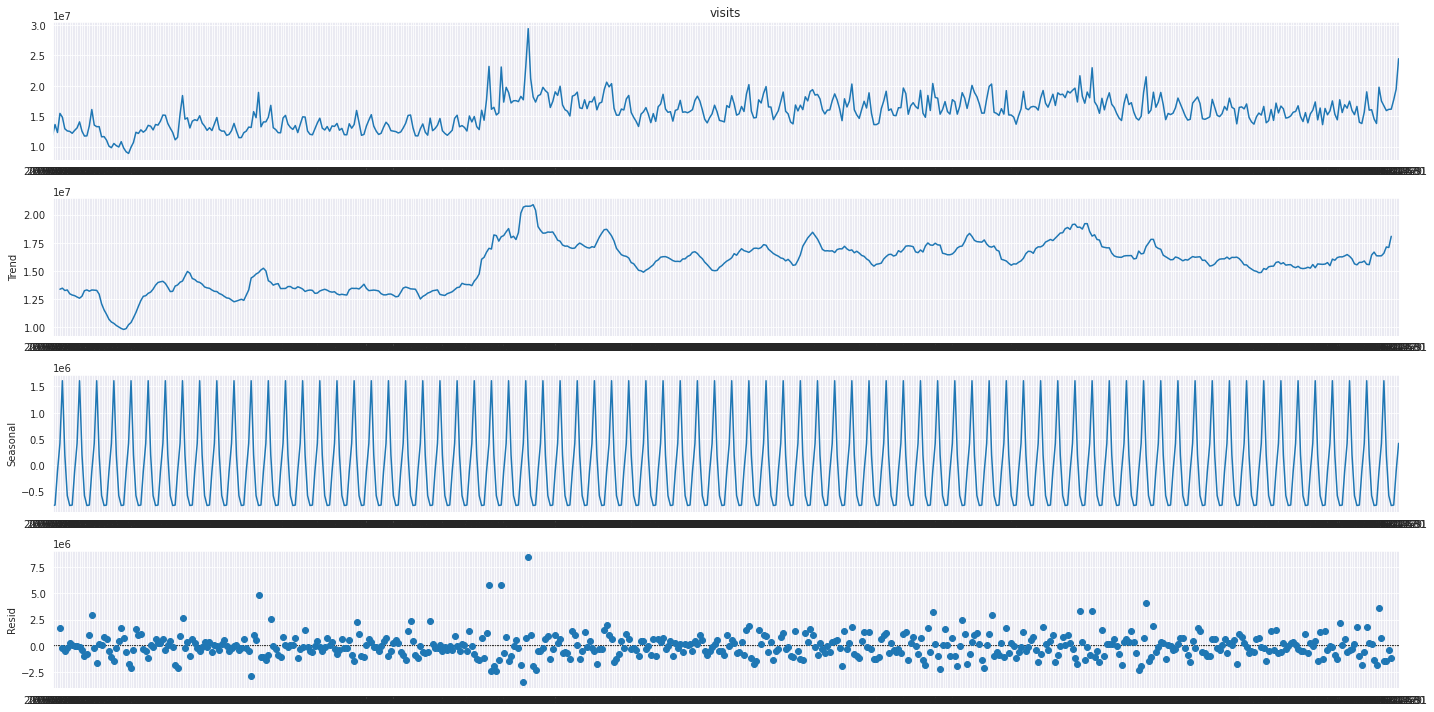

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


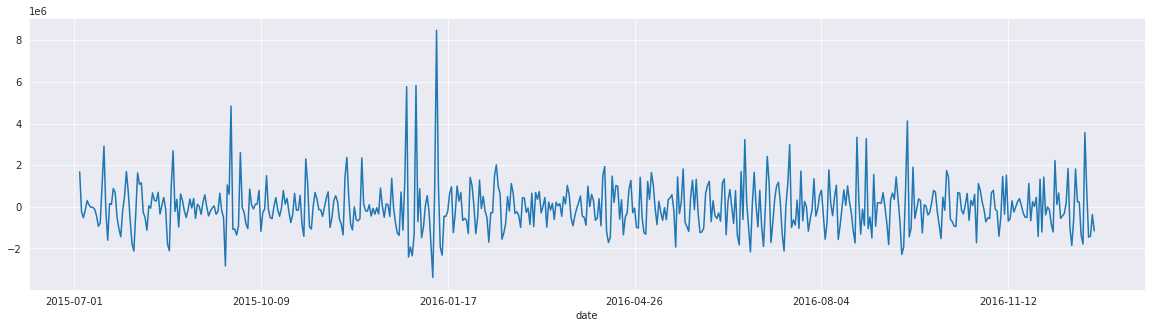

Trend plot from decomposed time series...


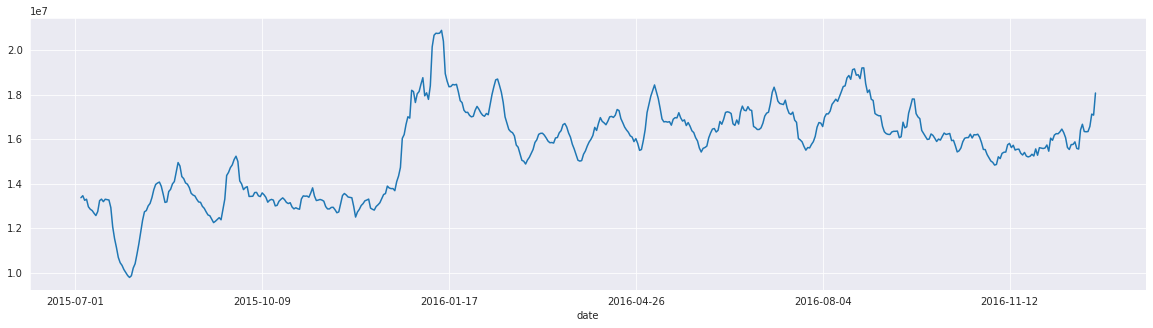

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


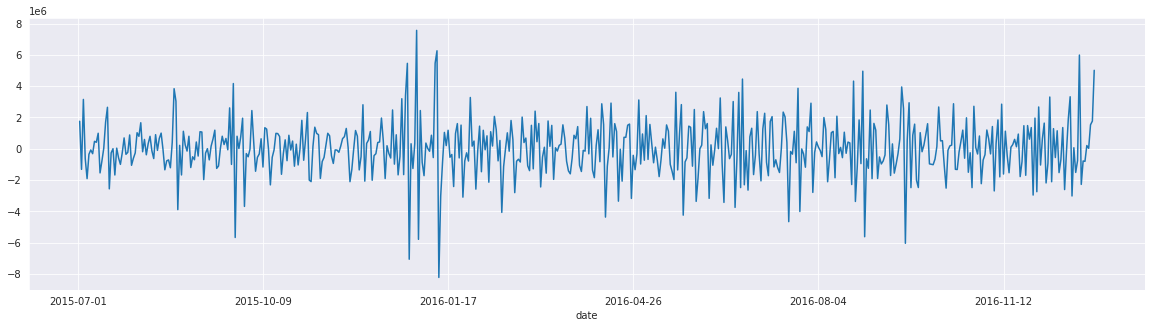

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


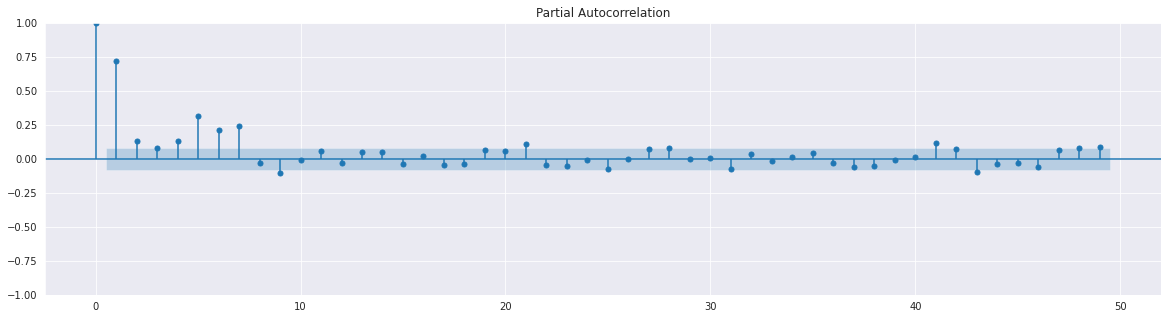

Pacf plot on seasonality...


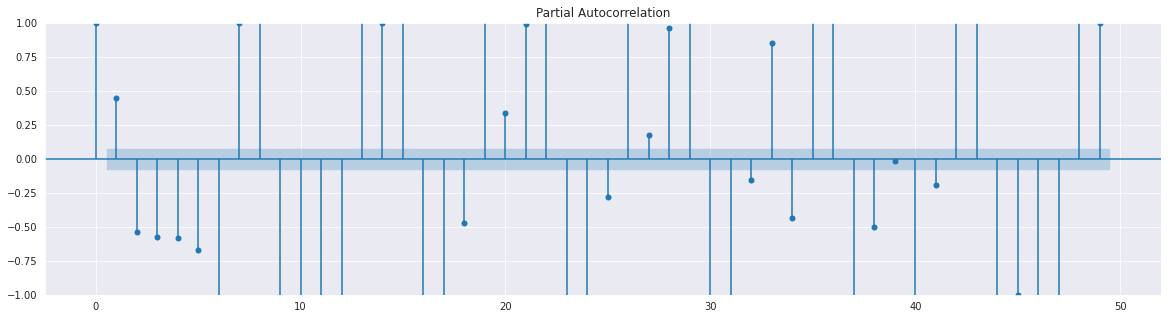

Acf plot on time series...


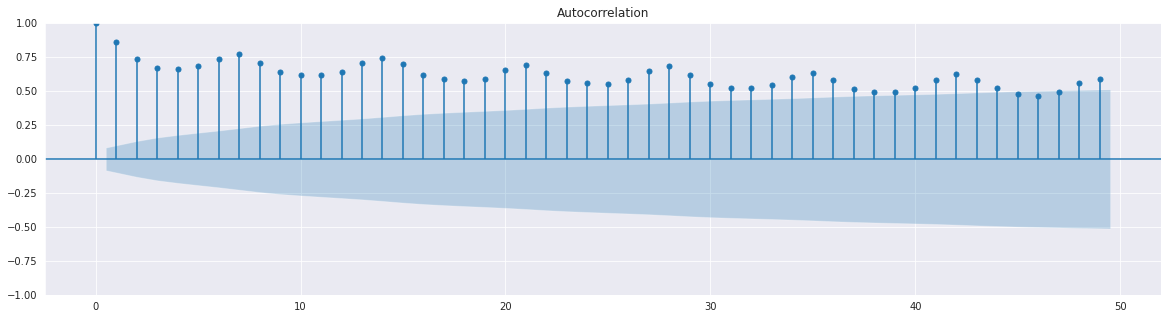

Acf plot on seasonality...


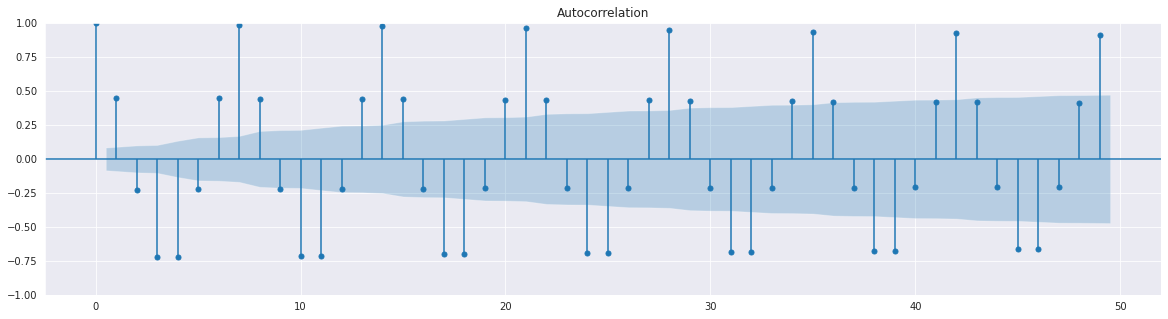

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


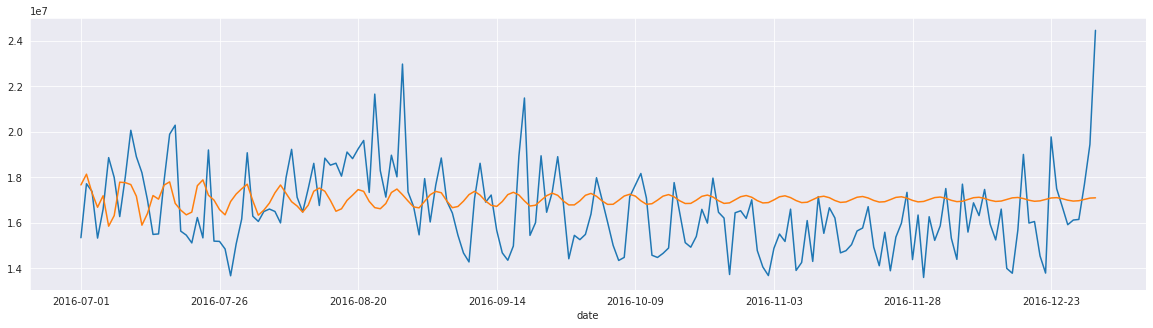

Performance of the model as below...
MAE  :  1482730.592
RMSE :  1844938.948
MAPE :  0.091
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


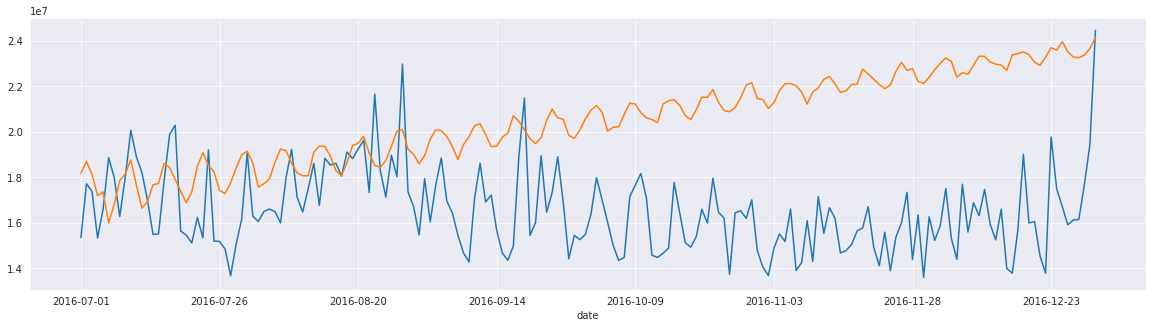

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance of the model as below...
MAE  :  4160479.994
RMSE :  4852998.068
MAPE :  0.265
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...
Initial log joint probability = -3.31249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       832.921    0.00563097       106.232           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       833.197   0.000331064       94.0271   4.225e-06       0.001      207  LS failed, Hessian reset 
     199       833.696   1.68676e-07       87.2982      0.5182      0.5182      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       833.696   2.71155e-08       68.2257      0.2625       0.686

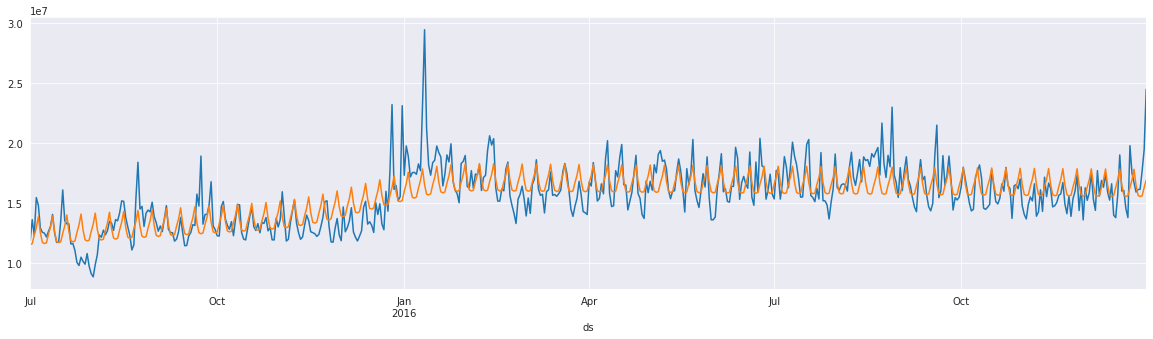

Performance of the model as below...
MAE  :  1229848.012
RMSE :  1733163.498
MAPE :  0.082
----------------------------------------------------------------------------------------------------



In [131]:
# Execute the pipeline for language ja

execute_pipeline(df_ja,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>Execute the forecast pipeline for es<b>

Sequence is stationary...
Seasonal decomposition starts... 
Decomposed time series...


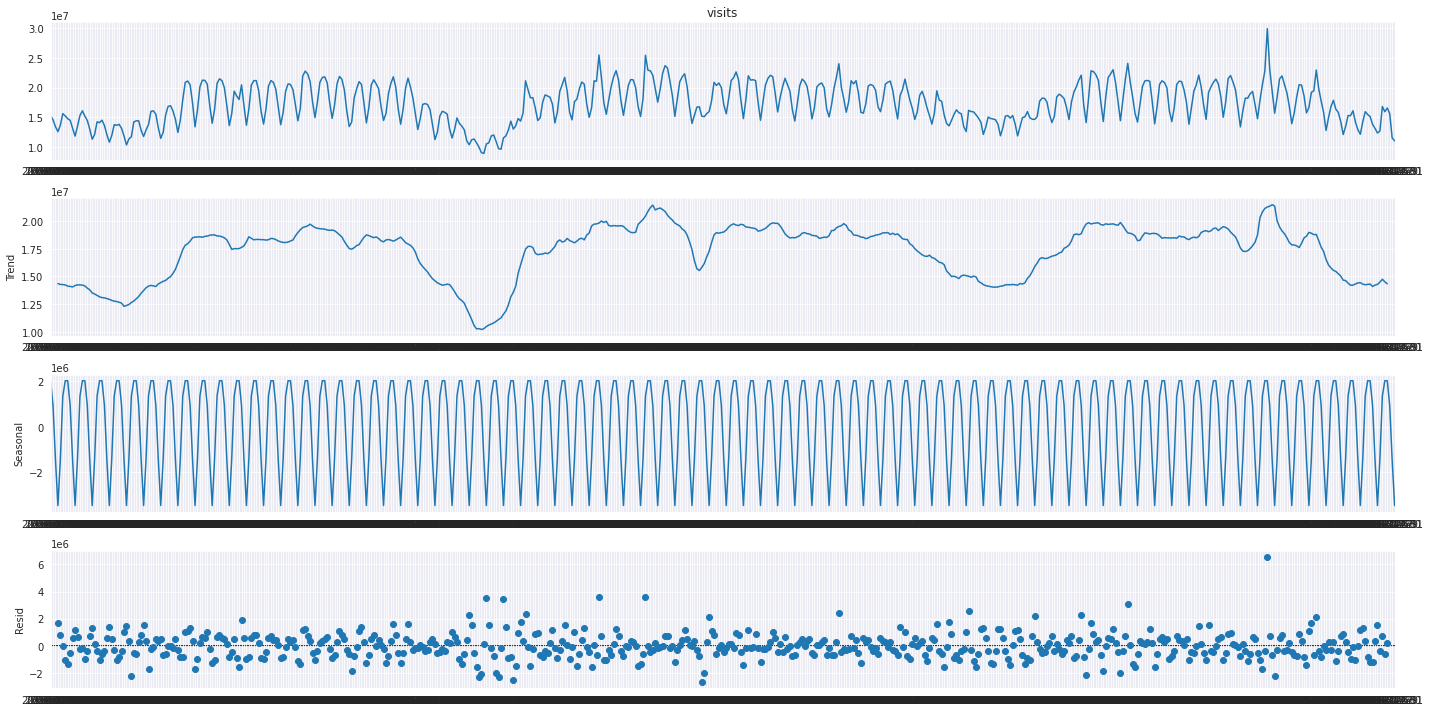

Residual plot from decomposed time series...
Dicky Fuller test for residual from decomposed time series...
Sequence is stationary...


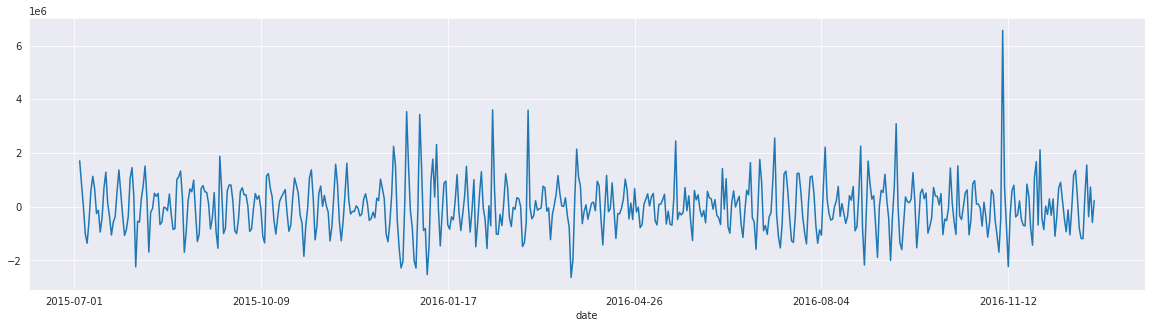

Trend plot from decomposed time series...


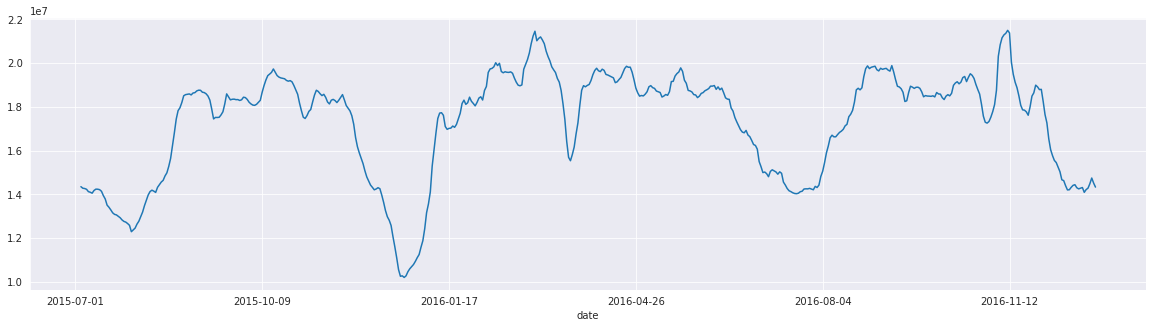

Performing first degree differencing on original time series...
Dicky Fuller test on differentiated time series...
Sequence is stationary...


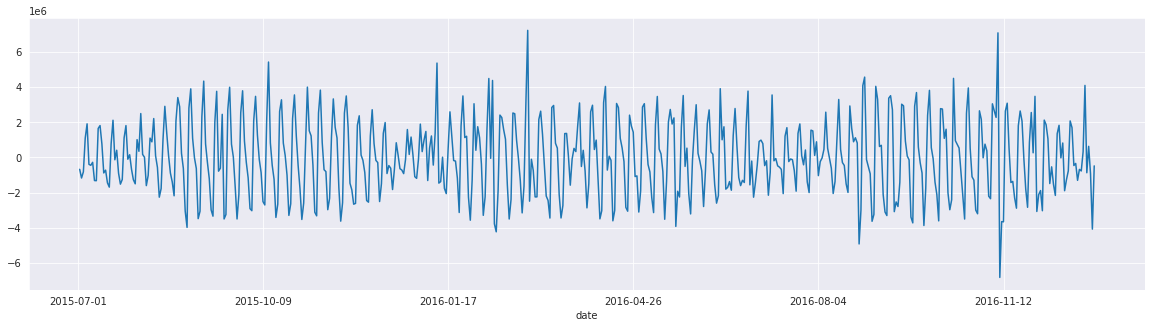

----------------------------------------------------------------------------------------------------

Creating seasonal decompose model for time series... 
Pacf plot on time series...


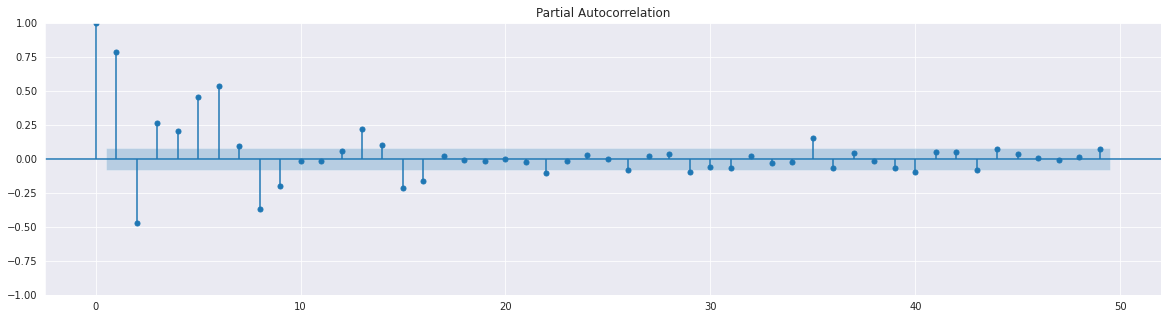

Pacf plot on seasonality...


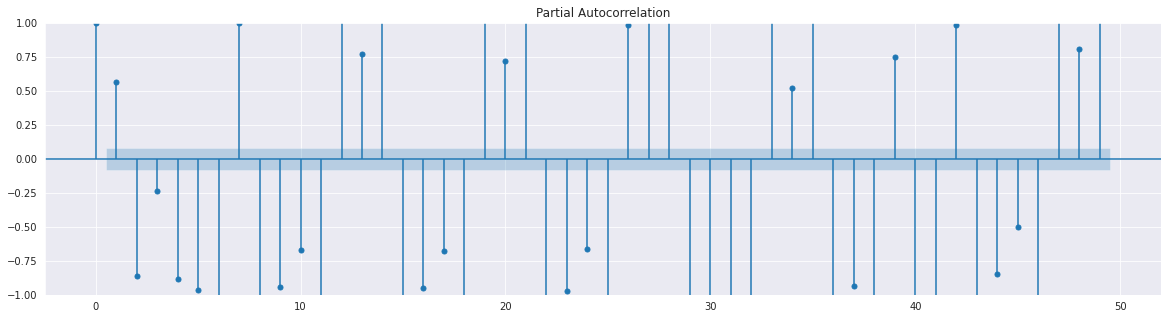

Acf plot on time series...


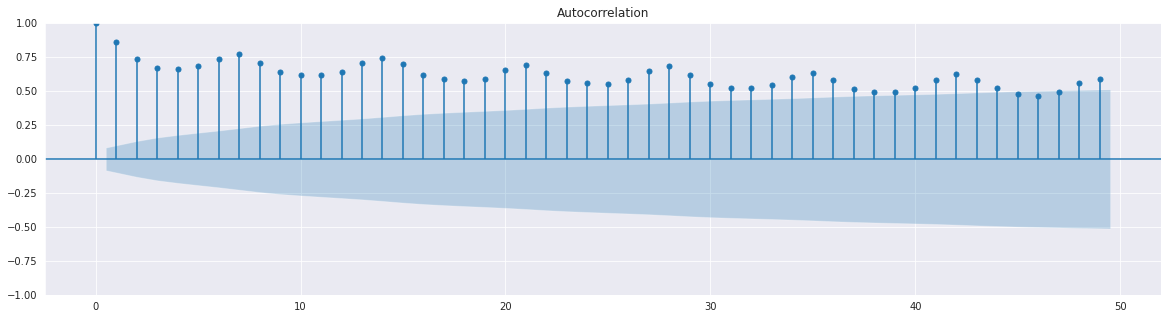

Acf plot on seasonality...


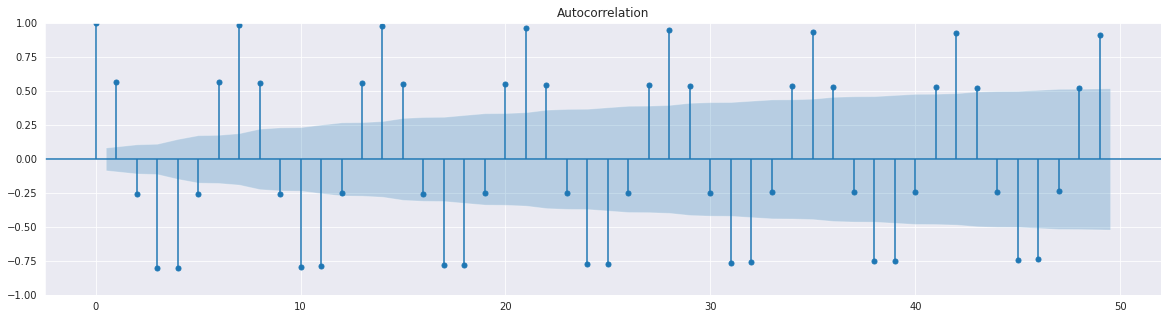

----------------------------------------------------------------------------------------------------

Splitting time series data into train and test... 
Shape of train and test data...
Train shape:  (366, 1)
Test shape :  (184, 1)
Making the train time series stationary...
Perform Dicky Fuller test to see if the train series has been made stationary...
Sequence is stationary...
----------------------------------------------------------------------------------------------------

ARIMA model forecasting... 
Splitting time series data into train and test...
Building and traing the model...


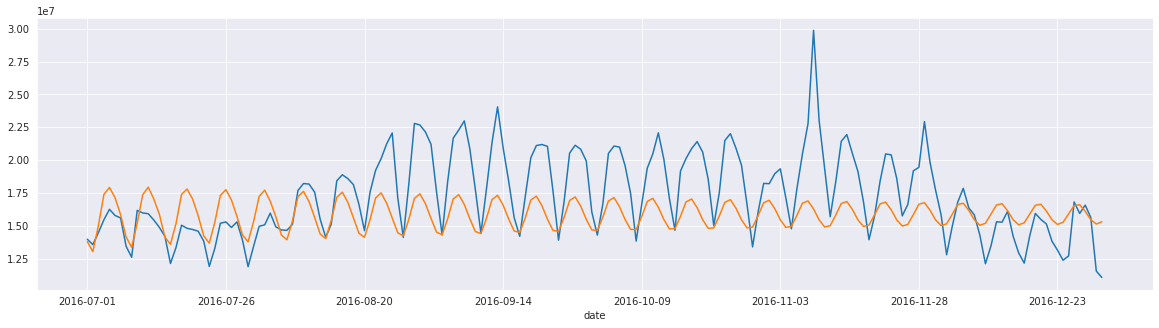

Performance of the model as below...
MAE  :  2418334.478
RMSE :  3078099.388
MAPE :  0.131
----------------------------------------------------------------------------------------------------

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


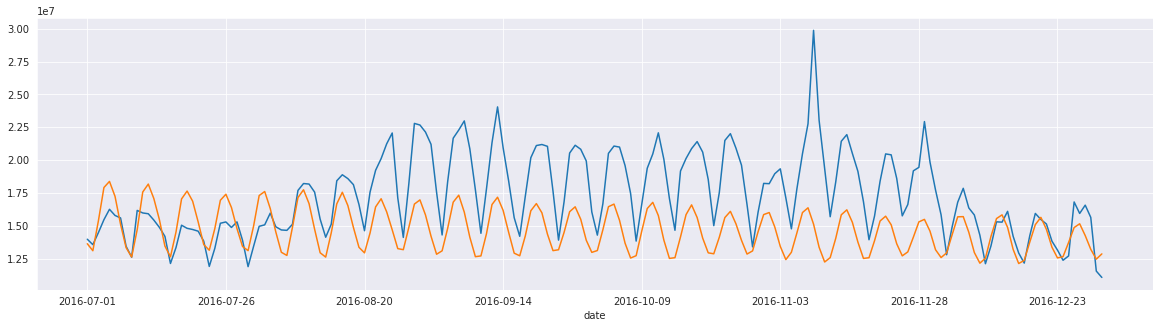

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance of the model as below...
MAE  :  3037966.968
RMSE :  3778847.885
MAPE :  0.162
----------------------------------------------------------------------------------------------------

Facebook prophet model forecasting...
Preparing data in required format for facebook prophet...
Building and training the model...
Initial log joint probability = -6.23169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       687.428    0.00240357       70.3361           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       690.644   0.000205831         75.45      0.3898           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       691.241    0.00241479       105.176   3.529e-05       0.001      392  LS failed, Hessian reset 
     299       691.442    0.00284446       101.399           1           1

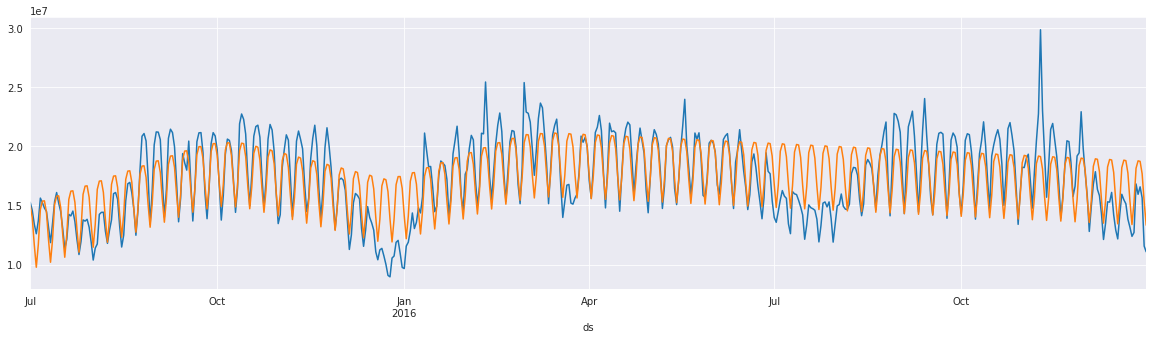

Performance of the model as below...
MAE  :  1357511.891
RMSE :  1863356.029
MAPE :  0.087
----------------------------------------------------------------------------------------------------



In [132]:
# Execute the pipeline for language es

execute_pipeline(df_es,cutoff=184,period=7,lags=49,p=7,d=1,q=8,P=1,D=1,Q=1,S=9,freq="D")

<b>SARIMA with exogenous variable<b>

In [54]:
# Import exogenous data

df_en_ex = pd.read_csv('Exog_Campaign_eng')

In [67]:
# Combine Exog data and English language time series data. Combining means add Exog column to df_en

df_en_ex['date'] = df_en.index.values
df_en_ex['visits'] = df_en['visits'].values
df_en_ex = df_en_ex.set_index('date')
df_en_ex = df_en_ex[['visits','Exog']]

In [105]:
# Define a sarimax model i.e.Sarima with Exog

def func_sarimax_model_forecast(data, cutoff=184, p=7, d=1, q=8, P=1, D=1, Q=1, S=9):
    
    print('\033[1mSARIMA model forecasting...\033[1m')
    print('\033[1mSplitting time series data into train and test...\033[1m')
    train_x = data[:-cutoff].copy()
    test_x  = data[-cutoff:].copy()
    
    start = len(train_x)
    end = len(train_x)+len(test_x)-1
    
    print('\033[1mBuilding and training the model...\033[1m')
    model = SARIMAX(train_x['visits'], exog=train_x['Exog'], order=(p,d,q),seasonal_order=(P,D,Q,S))
    model = model.fit(disp=False) 
    exog_forecast = test_x[['Exog']]  # requires two brackets to yield a shape of (184,1)
    predictions = model.predict(start=start, end=end, exog=exog_forecast)
    test_x['pred'] = predictions.values
    ax = test_x['visits'].plot(legend=True,figsize=(20,5))
    test_x['pred'].plot(legend=True, color='orange')
    ax.autoscale(axis='x',tight=True)
    for x in test_x.query('Exog==1').index:
        ax.axvline(x=x, color='red', alpha = 0.5);
    
    plt.show()
    
    print('\033[1mPerformance of the model as below...\033[1m')
    performance(test_x['visits'], predictions)
    print('-'*100)
    print()

SARIMA model forecasting...
Splitting time series data into train and test...
Building and training the model...


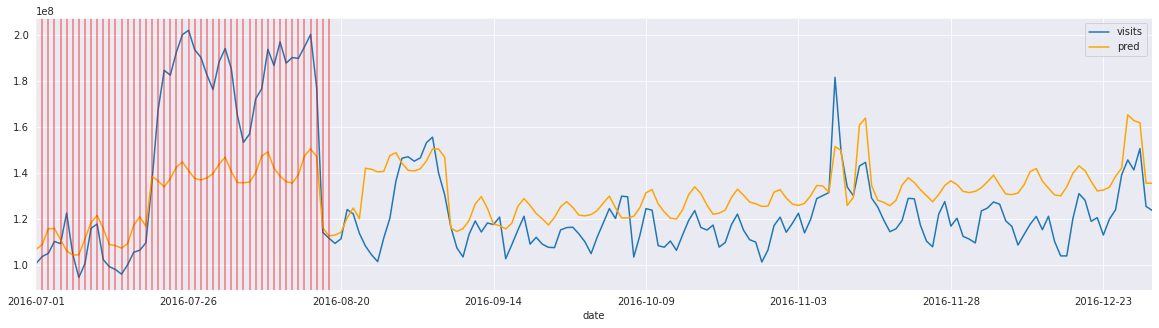

Performance of the model as below...
MAE  :  16605064.801
RMSE :  21606983.445
MAPE :  0.122
----------------------------------------------------------------------------------------------------



In [116]:
# Execute the Sarimax model with Exog

func_sarimax_model_forecast(df_en_ex, cutoff=184, p=7, d=1, q=8, P=1, D=1, Q=7, S=9)

<b>Business Insights and Recommendations:<b>

Business needs to decide which model to use for forecasting the number of visits to the particular webpage on any future date. Different forecast models with their respective performance are mentioned below.